# Comparison Reinforcement Learning vs. CFE Approach

In this notebook, the results of using Reinforcement Learning for controlling Burgers' Equation are compared to a supervised control force estimator approach using a differentiable physics loss function, which was proposed by Holl et al. [2020](https://ge.in.tum.de/publications/2020-iclr-holl). Both methods use the differentiable PDE solver [Φ<sub>Flow</sub>](https://github.com/tum-pbs/PhiFlow).
The reinforcement learning method also uses the [stable_baselines3](https://github.com/DLR-RM/stable-baselines3) RL framework and works with the [PPO](https://arxiv.org/abs/1707.06347v2) learning algorithm.

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard
import sys; sys.path.append('../src'); sys.path.append('../PDE-Control/PhiFlow'); sys.path.append('../PDE-Control/src')
from phi.flow import *
import burgers_plots as bplt
import matplotlib.pyplot as plt
from envs.burgers_util import GaussianClash, GaussianForce

## Data generation

At first, we will generate a suite of test scenes on which both methods will be evaluated.

In [2]:
domain = Domain([32], box=box[0:1])
viscosity = 0.003
step_count = 32
dt = 0.03
diffusion_substeps = 1

data_path = 'forced-burgers-clash'
scene_count = 1000
batch_size = 100

train_range = range(200, 1000)
val_range = range(100, 200)
test_range = range(0, 100)

In [3]:
for batch_index in range(scene_count // batch_size):
    scene = Scene.create(data_path, count=batch_size)
    print(scene)
    world = World()
    u0 = BurgersVelocity(
        domain, 
        velocity=GaussianClash(batch_size), 
        viscosity=viscosity, 
        batch_size=batch_size, 
        name='burgers'
    )
    u = world.add(u0, physics=Burgers(diffusion_substeps=diffusion_substeps))
    force = world.add(FieldEffect(GaussianForce(batch_size), ['velocity']))
    scene.write(world.state, frame=0)
    for frame in range(1, step_count + 1):
        world.step(dt=dt)
        scene.write(world.state, frame=frame)

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/phi/data/fluidformat.py:293: UserWarning:

Failed to copy calling script to scene during Scene.create().
Cause: [Errno 2] No such file or directory: '<ipython-input-3-fc5d3be44e31>'



forced-burgers-clash/sim_000000
forced-burgers-clash/sim_000100
forced-burgers-clash/sim_000200
forced-burgers-clash/sim_000300
forced-burgers-clash/sim_000400
forced-burgers-clash/sim_000500
forced-burgers-clash/sim_000600
forced-burgers-clash/sim_000700
forced-burgers-clash/sim_000800
forced-burgers-clash/sim_000900


## Reinforcement Learning initialization

In [3]:
from experiment import BurgersTraining

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWarning:

Passing (type, 1) or '1type' as a synony

In [4]:
n_envs = 10 # On how many environments to train in parallel, load balancing
final_reward_factor = step_count # How hard to punish the agent for not reaching the goal if that is the case
steps_per_rollout = step_count * 10 # How many steps to collect per environment between agent updates
n_epochs = 10 # How many epochs to perform during agent update
learning_rate = 1e-4 # Learning rate for agent updates
rl_batch_size = 128 # Batch size for agent updates

To start training, we create a trainer object, which manages the environment and the agent internally. Additionally, a directory for storing models, logs, and hyperparameters is created. This way, training can be continued at any later point using the same configuration. If the model folder specified in exp_name already exists, the agent within is loaded. Otherwise, a new agent is created

In [5]:
rl_trainer = BurgersTraining(
    exp_name='../networks/rl-models/ControlBurgersBench',
    domain=domain,
    viscosity=viscosity,
    step_count=step_count,
    dt=dt,
    diffusion_substeps=diffusion_substeps,
    n_envs=n_envs,
    final_reward_factor=final_reward_factor,
    steps_per_rollout=steps_per_rollout,
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    batch_size=rl_batch_size,
    test_path=data_path,
    test_range=test_range,
)

Loading existing agent from ../networks/rl-models/ControlBurgersBench/agent.zip


Now we are set up to start training the agent. The next line will take quite some time to execute, so grab a coffee or take your dog for a walk or so.

n_rollouts denotes the length of the training

save_freq specifies the number of epochs after which the stored model is overwritten


In [17]:
# Execute to run tensorboard
%tensorboard --logdir ../networks/rl-models/ControlBurgersBench/tensorboard-log

In [ ]:
rl_trainer.train(n_rollouts=1000, save_freq=50)

Logging to ../networks/rl-models/ControlBurgersBench/tensorboard-log/PPO_2
Storing agent and hyperparameters to disk...
Forces on test set: 595.131836
-----------------------------------
| forces             | 849.33685  |
| rew_unnormalized   | -5194.8433 |
| rollout/           |            |
|    ep_len_mean     | 32.0       |
|    ep_rew_mean     | 1.2473397  |
| test set forces    | 595        |
| time/              |            |
|    fps             | 684        |
|    iterations      | 1          |
|    time_elapsed    | 4          |
|    total_timesteps | 3200       |
-----------------------------------
Forces on test set: 593.975977
-----------------------------------------
| forces                  | 832.9147    |
| rew_unnormalized        | -5046.2085  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2572876   |
| test set forces         | 594         |
| time/                   |             |
|    fps      

Forces on test set: 593.017148
-----------------------------------------
| forces                  | 866.6545    |
| rew_unnormalized        | -4416.462   |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2973703   |
| test set forces         | 593         |
| time/                   |             |
|    fps                  | 261         |
|    iterations           | 10          |
|    time_elapsed         | 122         |
|    total_timesteps      | 32000       |
| train/                  |             |
|    approx_kl            | 0.044481803 |
|    clip_fraction        | 0.345       |
|    clip_range           | 0.2         |
|    entropy_loss         | -32         |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0557     |
|    n_updates            | 10090       |
|    policy_gradient_loss | -0.0264     |
|    std                  | 0.66        |
|  

Forces on test set: 594.329492
----------------------------------------
| forces                  | 762.35876  |
| rew_unnormalized        | -3734.5288 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.3414094  |
| test set forces         | 594        |
| time/                   |            |
|    fps                  | 232        |
|    iterations           | 18         |
|    time_elapsed         | 247        |
|    total_timesteps      | 57600      |
| train/                  |            |
|    approx_kl            | 0.04525759 |
|    clip_fraction        | 0.406      |
|    clip_range           | 0.2        |
|    entropy_loss         | -31.8      |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0172    |
|    n_updates            | 10170      |
|    policy_gradient_loss | -0.0151    |
|    std                  | 0.656      |
|    value_loss           

Forces on test set: 593.726055
-----------------------------------------
| forces                  | 830.2509    |
| rew_unnormalized        | -4025.6343  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.3153827   |
| test set forces         | 594         |
| time/                   |             |
|    fps                  | 218         |
|    iterations           | 26          |
|    time_elapsed         | 380         |
|    total_timesteps      | 83200       |
| train/                  |             |
|    approx_kl            | 0.047600485 |
|    clip_fraction        | 0.386       |
|    clip_range           | 0.2         |
|    entropy_loss         | -31.8       |
|    explained_variance   | 0.895       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0429     |
|    n_updates            | 10250       |
|    policy_gradient_loss | -0.0181     |
|    std                  | 0.654       |
|  

Forces on test set: 595.161641
----------------------------------------
| forces                  | 826.7713   |
| rew_unnormalized        | -4103.416  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.3046718  |
| test set forces         | 595        |
| time/                   |            |
|    fps                  | 208        |
|    iterations           | 34         |
|    time_elapsed         | 520        |
|    total_timesteps      | 108800     |
| train/                  |            |
|    approx_kl            | 0.04780064 |
|    clip_fraction        | 0.387      |
|    clip_range           | 0.2        |
|    entropy_loss         | -31.6      |
|    explained_variance   | 0.943      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0512    |
|    n_updates            | 10330      |
|    policy_gradient_loss | -0.0253    |
|    std                  | 0.652      |
|    value_loss           

Forces on test set: 593.203945
----------------------------------------
| forces                  | 827.69946  |
| rew_unnormalized        | -4761.662  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.2516557  |
| test set forces         | 593        |
| time/                   |            |
|    fps                  | 200        |
|    iterations           | 42         |
|    time_elapsed         | 669        |
|    total_timesteps      | 134400     |
| train/                  |            |
|    approx_kl            | 0.04635129 |
|    clip_fraction        | 0.385      |
|    clip_range           | 0.2        |
|    entropy_loss         | -31.5      |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0228    |
|    n_updates            | 10410      |
|    policy_gradient_loss | -0.027     |
|    std                  | 0.649      |
|    value_loss           

Forces on test set: 594.886875
Storing agent and hyperparameters to disk...
-----------------------------------------
| forces                  | 820.37695   |
| rew_unnormalized        | -4307.984   |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2800474   |
| test set forces         | 595         |
| time/                   |             |
|    fps                  | 200         |
|    iterations           | 50          |
|    time_elapsed         | 798         |
|    total_timesteps      | 160000      |
| train/                  |             |
|    approx_kl            | 0.019691426 |
|    clip_fraction        | 0.389       |
|    clip_range           | 0.2         |
|    entropy_loss         | -31.4       |
|    explained_variance   | 0.846       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0443     |
|    n_updates            | 10490       |
|    policy_gradient_loss | -0.0221     |


Forces on test set: 605.421992
-----------------------------------------
| forces                  | 797.113     |
| rew_unnormalized        | -3759.492   |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.3155339   |
| test set forces         | 605         |
| time/                   |             |
|    fps                  | 200         |
|    iterations           | 58          |
|    time_elapsed         | 927         |
|    total_timesteps      | 185600      |
| train/                  |             |
|    approx_kl            | 0.042888604 |
|    clip_fraction        | 0.368       |
|    clip_range           | 0.2         |
|    entropy_loss         | -31.2       |
|    explained_variance   | 0.944       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0262     |
|    n_updates            | 10570       |
|    policy_gradient_loss | -0.026      |
|    std                  | 0.643       |
|  

Forces on test set: 605.517773
-----------------------------------------
| forces                  | 830.42847   |
| rew_unnormalized        | -4120.9995  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2841122   |
| test set forces         | 606         |
| time/                   |             |
|    fps                  | 200         |
|    iterations           | 66          |
|    time_elapsed         | 1055        |
|    total_timesteps      | 211200      |
| train/                  |             |
|    approx_kl            | 0.038558487 |
|    clip_fraction        | 0.378       |
|    clip_range           | 0.2         |
|    entropy_loss         | -31.2       |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0307     |
|    n_updates            | 10650       |
|    policy_gradient_loss | -0.0204     |
|    std                  | 0.642       |
|  

Forces on test set: 612.905039
----------------------------------------
| forces                  | 806.9584   |
| rew_unnormalized        | -3911.6748 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.2948864  |
| test set forces         | 613        |
| time/                   |            |
|    fps                  | 199        |
|    iterations           | 74         |
|    time_elapsed         | 1185       |
|    total_timesteps      | 236800     |
| train/                  |            |
|    approx_kl            | 0.04306057 |
|    clip_fraction        | 0.378      |
|    clip_range           | 0.2        |
|    entropy_loss         | -31        |
|    explained_variance   | 0.969      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0454    |
|    n_updates            | 10730      |
|    policy_gradient_loss | -0.0252    |
|    std                  | 0.639      |
|    value_loss           

Forces on test set: 610.898633
-----------------------------------------
| forces                  | 828.51086   |
| rew_unnormalized        | -4273.7856  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2633017   |
| test set forces         | 611         |
| time/                   |             |
|    fps                  | 199         |
|    iterations           | 82          |
|    time_elapsed         | 1312        |
|    total_timesteps      | 262400      |
| train/                  |             |
|    approx_kl            | 0.028968718 |
|    clip_fraction        | 0.407       |
|    clip_range           | 0.2         |
|    entropy_loss         | -30.9       |
|    explained_variance   | 0.962       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0558     |
|    n_updates            | 10810       |
|    policy_gradient_loss | -0.0237     |
|    std                  | 0.636       |
|  

Forces on test set: 614.915586
----------------------------------------
| forces                  | 816.53125  |
| rew_unnormalized        | -3603.2659 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.3085719  |
| test set forces         | 615        |
| time/                   |            |
|    fps                  | 199        |
|    iterations           | 90         |
|    time_elapsed         | 1441       |
|    total_timesteps      | 288000     |
| train/                  |            |
|    approx_kl            | 0.04713237 |
|    clip_fraction        | 0.378      |
|    clip_range           | 0.2        |
|    entropy_loss         | -30.8      |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0586    |
|    n_updates            | 10890      |
|    policy_gradient_loss | -0.0247    |
|    std                  | 0.636      |
|    value_loss           

Forces on test set: 608.058398
-----------------------------------------
| forces                  | 868.6353    |
| rew_unnormalized        | -4737.7607  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2189754   |
| test set forces         | 608         |
| time/                   |             |
|    fps                  | 199         |
|    iterations           | 98          |
|    time_elapsed         | 1570        |
|    total_timesteps      | 313600      |
| train/                  |             |
|    approx_kl            | 0.064275324 |
|    clip_fraction        | 0.387       |
|    clip_range           | 0.2         |
|    entropy_loss         | -30.7       |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0332     |
|    n_updates            | 10970       |
|    policy_gradient_loss | -0.027      |
|    std                  | 0.632       |
|  

Forces on test set: 612.325000
----------------------------------------
| forces                  | 797.5464   |
| rew_unnormalized        | -4092.8289 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.2627027  |
| test set forces         | 612        |
| time/                   |            |
|    fps                  | 199        |
|    iterations           | 106        |
|    time_elapsed         | 1697       |
|    total_timesteps      | 339200     |
| train/                  |            |
|    approx_kl            | 0.03765102 |
|    clip_fraction        | 0.375      |
|    clip_range           | 0.2        |
|    entropy_loss         | -30.6      |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0298    |
|    n_updates            | 11050      |
|    policy_gradient_loss | -0.0283    |
|    std                  | 0.63       |
|    value_loss           

Forces on test set: 603.953203
-----------------------------------------
| forces                  | 815.3373    |
| rew_unnormalized        | -5123.4785  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.1802982   |
| test set forces         | 604         |
| time/                   |             |
|    fps                  | 199         |
|    iterations           | 114         |
|    time_elapsed         | 1824        |
|    total_timesteps      | 364800      |
| train/                  |             |
|    approx_kl            | 0.026957871 |
|    clip_fraction        | 0.41        |
|    clip_range           | 0.2         |
|    entropy_loss         | -30.4       |
|    explained_variance   | 0.862       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0325     |
|    n_updates            | 11130       |
|    policy_gradient_loss | -0.0181     |
|    std                  | 0.627       |
|  

Forces on test set: 612.185234
-----------------------------------------
| forces                  | 831.72656   |
| rew_unnormalized        | -3736.7012  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2805109   |
| test set forces         | 612         |
| time/                   |             |
|    fps                  | 200         |
|    iterations           | 122         |
|    time_elapsed         | 1951        |
|    total_timesteps      | 390400      |
| train/                  |             |
|    approx_kl            | 0.031418167 |
|    clip_fraction        | 0.377       |
|    clip_range           | 0.2         |
|    entropy_loss         | -30.3       |
|    explained_variance   | 0.952       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0357     |
|    n_updates            | 11210       |
|    policy_gradient_loss | -0.0287     |
|    std                  | 0.626       |
|  

Forces on test set: 608.496758
-----------------------------------------
| forces                  | 807.0506    |
| rew_unnormalized        | -3993.2393  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2566739   |
| test set forces         | 608         |
| time/                   |             |
|    fps                  | 200         |
|    iterations           | 130         |
|    time_elapsed         | 2078        |
|    total_timesteps      | 416000      |
| train/                  |             |
|    approx_kl            | 0.026040861 |
|    clip_fraction        | 0.376       |
|    clip_range           | 0.2         |
|    entropy_loss         | -30.2       |
|    explained_variance   | 0.808       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0485     |
|    n_updates            | 11290       |
|    policy_gradient_loss | -0.022      |
|    std                  | 0.623       |
|  

Forces on test set: 598.603867
-----------------------------------------
| forces                  | 804.8268    |
| rew_unnormalized        | -3595.039   |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2826251   |
| test set forces         | 599         |
| time/                   |             |
|    fps                  | 200         |
|    iterations           | 138         |
|    time_elapsed         | 2205        |
|    total_timesteps      | 441600      |
| train/                  |             |
|    approx_kl            | 0.040346604 |
|    clip_fraction        | 0.426       |
|    clip_range           | 0.2         |
|    entropy_loss         | -30.1       |
|    explained_variance   | 0.911       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0155     |
|    n_updates            | 11370       |
|    policy_gradient_loss | -0.0198     |
|    std                  | 0.621       |
|  

Forces on test set: 605.734258
-----------------------------------------
| forces                  | 822.99084   |
| rew_unnormalized        | -3731.0498  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2678931   |
| test set forces         | 606         |
| time/                   |             |
|    fps                  | 200         |
|    iterations           | 146         |
|    time_elapsed         | 2331        |
|    total_timesteps      | 467200      |
| train/                  |             |
|    approx_kl            | 0.041157734 |
|    clip_fraction        | 0.358       |
|    clip_range           | 0.2         |
|    entropy_loss         | -30         |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0224     |
|    n_updates            | 11450       |
|    policy_gradient_loss | -0.0297     |
|    std                  | 0.618       |
|  

Forces on test set: 603.932188
-----------------------------------------
| forces                  | 800.4846    |
| rew_unnormalized        | -3592.6633  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.27417     |
| test set forces         | 604         |
| time/                   |             |
|    fps                  | 200         |
|    iterations           | 154         |
|    time_elapsed         | 2457        |
|    total_timesteps      | 492800      |
| train/                  |             |
|    approx_kl            | 0.041379794 |
|    clip_fraction        | 0.397       |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.7       |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.027      |
|    n_updates            | 11530       |
|    policy_gradient_loss | -0.0332     |
|    std                  | 0.613       |
|  

Forces on test set: 603.795039
-----------------------------------------
| forces                  | 817.5008    |
| rew_unnormalized        | -4202.974   |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2227623   |
| test set forces         | 604         |
| time/                   |             |
|    fps                  | 200         |
|    iterations           | 162         |
|    time_elapsed         | 2585        |
|    total_timesteps      | 518400      |
| train/                  |             |
|    approx_kl            | 0.047050986 |
|    clip_fraction        | 0.4         |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.5       |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.06       |
|    n_updates            | 11610       |
|    policy_gradient_loss | -0.033      |
|    std                  | 0.61        |
|  

Forces on test set: 602.347617
-----------------------------------------
| forces                  | 793.4828    |
| rew_unnormalized        | -3840.4333  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2464267   |
| test set forces         | 602         |
| time/                   |             |
|    fps                  | 200         |
|    iterations           | 170         |
|    time_elapsed         | 2712        |
|    total_timesteps      | 544000      |
| train/                  |             |
|    approx_kl            | 0.046681903 |
|    clip_fraction        | 0.415       |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.4       |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0324     |
|    n_updates            | 11690       |
|    policy_gradient_loss | -0.0266     |
|    std                  | 0.607       |
|  

Forces on test set: 599.982305
----------------------------------------
| forces                  | 804.16705  |
| rew_unnormalized        | -3602.9197 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.2606026  |
| test set forces         | 600        |
| time/                   |            |
|    fps                  | 200        |
|    iterations           | 178        |
|    time_elapsed         | 2842       |
|    total_timesteps      | 569600     |
| train/                  |            |
|    approx_kl            | 0.05273405 |
|    clip_fraction        | 0.397      |
|    clip_range           | 0.2        |
|    entropy_loss         | -29.2      |
|    explained_variance   | 0.969      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0572    |
|    n_updates            | 11770      |
|    policy_gradient_loss | -0.0256    |
|    std                  | 0.605      |
|    value_loss           

Forces on test set: 606.136094
-----------------------------------------
| forces                  | 803.0393    |
| rew_unnormalized        | -4146.5586  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2140774   |
| test set forces         | 606         |
| time/                   |             |
|    fps                  | 200         |
|    iterations           | 186         |
|    time_elapsed         | 2969        |
|    total_timesteps      | 595200      |
| train/                  |             |
|    approx_kl            | 0.034598995 |
|    clip_fraction        | 0.39        |
|    clip_range           | 0.2         |
|    entropy_loss         | -29         |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0381     |
|    n_updates            | 11850       |
|    policy_gradient_loss | -0.0263     |
|    std                  | 0.6         |
|  

Forces on test set: 604.925313
----------------------------------------
| forces                  | 779.1979   |
| rew_unnormalized        | -3732.0881 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.2421863  |
| test set forces         | 605        |
| time/                   |            |
|    fps                  | 200        |
|    iterations           | 194        |
|    time_elapsed         | 3097       |
|    total_timesteps      | 620800     |
| train/                  |            |
|    approx_kl            | 0.03860413 |
|    clip_fraction        | 0.434      |
|    clip_range           | 0.2        |
|    entropy_loss         | -28.9      |
|    explained_variance   | 0.941      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0613    |
|    n_updates            | 11930      |
|    policy_gradient_loss | -0.0209    |
|    std                  | 0.598      |
|    value_loss           

Forces on test set: 608.067656
-----------------------------------------
| forces                  | 785.604     |
| rew_unnormalized        | -3390.988   |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2647907   |
| test set forces         | 608         |
| time/                   |             |
|    fps                  | 200         |
|    iterations           | 202         |
|    time_elapsed         | 3225        |
|    total_timesteps      | 646400      |
| train/                  |             |
|    approx_kl            | 0.049299166 |
|    clip_fraction        | 0.409       |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.8       |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0449     |
|    n_updates            | 12010       |
|    policy_gradient_loss | -0.0261     |
|    std                  | 0.596       |
|  

Forces on test set: 599.845469
-----------------------------------------
| forces                  | 800.0274    |
| rew_unnormalized        | -4123.2017  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2032677   |
| test set forces         | 600         |
| time/                   |             |
|    fps                  | 200         |
|    iterations           | 210         |
|    time_elapsed         | 3347        |
|    total_timesteps      | 672000      |
| train/                  |             |
|    approx_kl            | 0.038182657 |
|    clip_fraction        | 0.421       |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.6       |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0371     |
|    n_updates            | 12090       |
|    policy_gradient_loss | -0.0263     |
|    std                  | 0.592       |
|  

Forces on test set: 597.008594
-----------------------------------------
| forces                  | 814.3975    |
| rew_unnormalized        | -4113.001   |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.1999183   |
| test set forces         | 597         |
| time/                   |             |
|    fps                  | 200         |
|    iterations           | 218         |
|    time_elapsed         | 3472        |
|    total_timesteps      | 697600      |
| train/                  |             |
|    approx_kl            | 0.047239963 |
|    clip_fraction        | 0.374       |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.5       |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0264     |
|    n_updates            | 12170       |
|    policy_gradient_loss | -0.0169     |
|    std                  | 0.59        |
|  

Forces on test set: 606.593633
----------------------------------------
| forces                  | 811.92224  |
| rew_unnormalized        | -3844.7566 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.217088   |
| test set forces         | 607        |
| time/                   |            |
|    fps                  | 201        |
|    iterations           | 226        |
|    time_elapsed         | 3597       |
|    total_timesteps      | 723200     |
| train/                  |            |
|    approx_kl            | 0.03376017 |
|    clip_fraction        | 0.433      |
|    clip_range           | 0.2        |
|    entropy_loss         | -28.4      |
|    explained_variance   | 0.932      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0243    |
|    n_updates            | 12250      |
|    policy_gradient_loss | -0.0245    |
|    std                  | 0.59       |
|    value_loss           

Forces on test set: 614.692969
----------------------------------------
| forces                  | 811.0622   |
| rew_unnormalized        | -3509.372  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.2396373  |
| test set forces         | 615        |
| time/                   |            |
|    fps                  | 201        |
|    iterations           | 234        |
|    time_elapsed         | 3721       |
|    total_timesteps      | 748800     |
| train/                  |            |
|    approx_kl            | 0.03012223 |
|    clip_fraction        | 0.421      |
|    clip_range           | 0.2        |
|    entropy_loss         | -28.4      |
|    explained_variance   | 0.954      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0372    |
|    n_updates            | 12330      |
|    policy_gradient_loss | -0.0236    |
|    std                  | 0.588      |
|    value_loss           

Forces on test set: 617.575469
----------------------------------------
| forces                  | 819.39264  |
| rew_unnormalized        | -4007.125  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1960075  |
| test set forces         | 618        |
| time/                   |            |
|    fps                  | 201        |
|    iterations           | 242        |
|    time_elapsed         | 3846       |
|    total_timesteps      | 774400     |
| train/                  |            |
|    approx_kl            | 0.06281363 |
|    clip_fraction        | 0.409      |
|    clip_range           | 0.2        |
|    entropy_loss         | -28.2      |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00826   |
|    n_updates            | 12410      |
|    policy_gradient_loss | -0.0212    |
|    std                  | 0.586      |
|    value_loss           

Forces on test set: 616.033320
Storing agent and hyperparameters to disk...
-----------------------------------------
| forces                  | 815.2034    |
| rew_unnormalized        | -3537.8093  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2294669   |
| test set forces         | 616         |
| time/                   |             |
|    fps                  | 201         |
|    iterations           | 250         |
|    time_elapsed         | 3971        |
|    total_timesteps      | 800000      |
| train/                  |             |
|    approx_kl            | 0.049114462 |
|    clip_fraction        | 0.43        |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.1       |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0385     |
|    n_updates            | 12490       |
|    policy_gradient_loss | -0.0319     |


Forces on test set: 612.864531
---------------------------------------
| forces                  | 768.12274 |
| rew_unnormalized        | -3621.614 |
| rollout/                |           |
|    ep_len_mean          | 32.0      |
|    ep_rew_mean          | 1.2187563 |
| test set forces         | 613       |
| time/                   |           |
|    fps                  | 201       |
|    iterations           | 258       |
|    time_elapsed         | 4095      |
|    total_timesteps      | 825600    |
| train/                  |           |
|    approx_kl            | 0.0428049 |
|    clip_fraction        | 0.425     |
|    clip_range           | 0.2       |
|    entropy_loss         | -27.9     |
|    explained_variance   | 0.937     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.00106  |
|    n_updates            | 12570     |
|    policy_gradient_loss | -0.0205   |
|    std                  | 0.58      |
|    value_loss           | 0.00477   |
---------

Forces on test set: 620.499727
----------------------------------------
| forces                  | 826.21564  |
| rew_unnormalized        | -3704.3425 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.2082212  |
| test set forces         | 620        |
| time/                   |            |
|    fps                  | 201        |
|    iterations           | 266        |
|    time_elapsed         | 4219       |
|    total_timesteps      | 851200     |
| train/                  |            |
|    approx_kl            | 0.04238229 |
|    clip_fraction        | 0.444      |
|    clip_range           | 0.2        |
|    entropy_loss         | -27.8      |
|    explained_variance   | 0.969      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0527    |
|    n_updates            | 12650      |
|    policy_gradient_loss | -0.0291    |
|    std                  | 0.578      |
|    value_loss           

Forces on test set: 614.960234
----------------------------------------
| forces                  | 767.2347   |
| rew_unnormalized        | -3191.805  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.245617   |
| test set forces         | 615        |
| time/                   |            |
|    fps                  | 201        |
|    iterations           | 274        |
|    time_elapsed         | 4344       |
|    total_timesteps      | 876800     |
| train/                  |            |
|    approx_kl            | 0.06343062 |
|    clip_fraction        | 0.425      |
|    clip_range           | 0.2        |
|    entropy_loss         | -27.6      |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0456    |
|    n_updates            | 12730      |
|    policy_gradient_loss | -0.027     |
|    std                  | 0.575      |
|    value_loss           

Forces on test set: 616.895313
----------------------------------------
| forces                  | 810.7584   |
| rew_unnormalized        | -3589.7834 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.2096325  |
| test set forces         | 617        |
| time/                   |            |
|    fps                  | 202        |
|    iterations           | 282        |
|    time_elapsed         | 4466       |
|    total_timesteps      | 902400     |
| train/                  |            |
|    approx_kl            | 0.05482893 |
|    clip_fraction        | 0.431      |
|    clip_range           | 0.2        |
|    entropy_loss         | -27.4      |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0545    |
|    n_updates            | 12810      |
|    policy_gradient_loss | -0.03      |
|    std                  | 0.572      |
|    value_loss           

Forces on test set: 611.393594
-----------------------------------------
| forces                  | 809.0797    |
| rew_unnormalized        | -3363.4697  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2241395   |
| test set forces         | 611         |
| time/                   |             |
|    fps                  | 202         |
|    iterations           | 290         |
|    time_elapsed         | 4589        |
|    total_timesteps      | 928000      |
| train/                  |             |
|    approx_kl            | 0.042783495 |
|    clip_fraction        | 0.397       |
|    clip_range           | 0.2         |
|    entropy_loss         | -27.3       |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0317     |
|    n_updates            | 12890       |
|    policy_gradient_loss | -0.0269     |
|    std                  | 0.569       |
|  

Forces on test set: 613.555547
----------------------------------------
| forces                  | 796.258    |
| rew_unnormalized        | -3445.4463 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.2136153  |
| test set forces         | 614        |
| time/                   |            |
|    fps                  | 202        |
|    iterations           | 298        |
|    time_elapsed         | 4713       |
|    total_timesteps      | 953600     |
| train/                  |            |
|    approx_kl            | 0.04417752 |
|    clip_fraction        | 0.401      |
|    clip_range           | 0.2        |
|    entropy_loss         | -27.2      |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0518    |
|    n_updates            | 12970      |
|    policy_gradient_loss | -0.0261    |
|    std                  | 0.567      |
|    value_loss           

Forces on test set: 610.030078
----------------------------------------
| forces                  | 774.868    |
| rew_unnormalized        | -3186.1953 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.230958   |
| test set forces         | 610        |
| time/                   |            |
|    fps                  | 202        |
|    iterations           | 306        |
|    time_elapsed         | 4837       |
|    total_timesteps      | 979200     |
| train/                  |            |
|    approx_kl            | 0.03366349 |
|    clip_fraction        | 0.397      |
|    clip_range           | 0.2        |
|    entropy_loss         | -27        |
|    explained_variance   | 0.952      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0387    |
|    n_updates            | 13050      |
|    policy_gradient_loss | -0.0234    |
|    std                  | 0.564      |
|    value_loss           

Forces on test set: 609.856133
----------------------------------------
| forces                  | 809.3847   |
| rew_unnormalized        | -3336.8726 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.2148774  |
| test set forces         | 610        |
| time/                   |            |
|    fps                  | 202        |
|    iterations           | 314        |
|    time_elapsed         | 4962       |
|    total_timesteps      | 1004800    |
| train/                  |            |
|    approx_kl            | 0.04164006 |
|    clip_fraction        | 0.378      |
|    clip_range           | 0.2        |
|    entropy_loss         | -26.8      |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0435    |
|    n_updates            | 13130      |
|    policy_gradient_loss | -0.0286    |
|    std                  | 0.56       |
|    value_loss           

Forces on test set: 611.520039
-----------------------------------------
| forces                  | 793.3052    |
| rew_unnormalized        | -3213.4307  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2212635   |
| test set forces         | 612         |
| time/                   |             |
|    fps                  | 202         |
|    iterations           | 322         |
|    time_elapsed         | 5086        |
|    total_timesteps      | 1030400     |
| train/                  |             |
|    approx_kl            | 0.042216636 |
|    clip_fraction        | 0.427       |
|    clip_range           | 0.2         |
|    entropy_loss         | -26.7       |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0352     |
|    n_updates            | 13210       |
|    policy_gradient_loss | -0.0221     |
|    std                  | 0.559       |
|  

Forces on test set: 606.744375
-----------------------------------------
| forces                  | 791.09204   |
| rew_unnormalized        | -2985.05    |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2364234   |
| test set forces         | 607         |
| time/                   |             |
|    fps                  | 202         |
|    iterations           | 330         |
|    time_elapsed         | 5211        |
|    total_timesteps      | 1056000     |
| train/                  |             |
|    approx_kl            | 0.039223205 |
|    clip_fraction        | 0.435       |
|    clip_range           | 0.2         |
|    entropy_loss         | -26.6       |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0383     |
|    n_updates            | 13290       |
|    policy_gradient_loss | -0.0256     |
|    std                  | 0.556       |
|  

Forces on test set: 608.278281
-----------------------------------------
| forces                  | 775.02075   |
| rew_unnormalized        | -2833.4465  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2453456   |
| test set forces         | 608         |
| time/                   |             |
|    fps                  | 202         |
|    iterations           | 338         |
|    time_elapsed         | 5335        |
|    total_timesteps      | 1081600     |
| train/                  |             |
|    approx_kl            | 0.011322414 |
|    clip_fraction        | 0.415       |
|    clip_range           | 0.2         |
|    entropy_loss         | -26.5       |
|    explained_variance   | 0.94        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0129     |
|    n_updates            | 13370       |
|    policy_gradient_loss | -0.0235     |
|    std                  | 0.555       |
|  

Forces on test set: 601.272148
----------------------------------------
| forces                  | 821.8204   |
| rew_unnormalized        | -3436.745  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1917686  |
| test set forces         | 601        |
| time/                   |            |
|    fps                  | 202        |
|    iterations           | 346        |
|    time_elapsed         | 5459       |
|    total_timesteps      | 1107200    |
| train/                  |            |
|    approx_kl            | 0.08340191 |
|    clip_fraction        | 0.421      |
|    clip_range           | 0.2        |
|    entropy_loss         | -26.3      |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.068     |
|    n_updates            | 13450      |
|    policy_gradient_loss | -0.0334    |
|    std                  | 0.552      |
|    value_loss           

Forces on test set: 604.475312
-----------------------------------------
| forces                  | 765.8219    |
| rew_unnormalized        | -2878.6494  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2344794   |
| test set forces         | 604         |
| time/                   |             |
|    fps                  | 202         |
|    iterations           | 354         |
|    time_elapsed         | 5581        |
|    total_timesteps      | 1132800     |
| train/                  |             |
|    approx_kl            | 0.041795827 |
|    clip_fraction        | 0.399       |
|    clip_range           | 0.2         |
|    entropy_loss         | -26.2       |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0327     |
|    n_updates            | 13530       |
|    policy_gradient_loss | -0.0258     |
|    std                  | 0.55        |
|  

Forces on test set: 613.333281
-----------------------------------------
| forces                  | 744.5232    |
| rew_unnormalized        | -2982.6108  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2222248   |
| test set forces         | 613         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 362         |
|    time_elapsed         | 5704        |
|    total_timesteps      | 1158400     |
| train/                  |             |
|    approx_kl            | 0.061829805 |
|    clip_fraction        | 0.435       |
|    clip_range           | 0.2         |
|    entropy_loss         | -26.1       |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0351     |
|    n_updates            | 13610       |
|    policy_gradient_loss | -0.024      |
|    std                  | 0.549       |
|  

Forces on test set: 606.498789
----------------------------------------
| forces                  | 787.5246   |
| rew_unnormalized        | -2996.365  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.2175406  |
| test set forces         | 606        |
| time/                   |            |
|    fps                  | 203        |
|    iterations           | 370        |
|    time_elapsed         | 5830       |
|    total_timesteps      | 1184000    |
| train/                  |            |
|    approx_kl            | 0.05510874 |
|    clip_fraction        | 0.432      |
|    clip_range           | 0.2        |
|    entropy_loss         | -26        |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0429    |
|    n_updates            | 13690      |
|    policy_gradient_loss | -0.0299    |
|    std                  | 0.546      |
|    value_loss           

Forces on test set: 614.115430
-----------------------------------------
| forces                  | 783.70544   |
| rew_unnormalized        | -3029.9568  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2112274   |
| test set forces         | 614         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 378         |
|    time_elapsed         | 5955        |
|    total_timesteps      | 1209600     |
| train/                  |             |
|    approx_kl            | 0.049701773 |
|    clip_fraction        | 0.456       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.8       |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0138     |
|    n_updates            | 13770       |
|    policy_gradient_loss | -0.0221     |
|    std                  | 0.543       |
|  

Forces on test set: 614.796484
----------------------------------------
| forces                  | 804.56226  |
| rew_unnormalized        | -3363.179  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1797588  |
| test set forces         | 615        |
| time/                   |            |
|    fps                  | 203        |
|    iterations           | 386        |
|    time_elapsed         | 6081       |
|    total_timesteps      | 1235200    |
| train/                  |            |
|    approx_kl            | 0.06338855 |
|    clip_fraction        | 0.435      |
|    clip_range           | 0.2        |
|    entropy_loss         | -25.7      |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00961   |
|    n_updates            | 13850      |
|    policy_gradient_loss | -0.0238    |
|    std                  | 0.542      |
|    value_loss           

Forces on test set: 617.636641
----------------------------------------
| forces                  | 766.77704  |
| rew_unnormalized        | -3009.5522 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.2061267  |
| test set forces         | 618        |
| time/                   |            |
|    fps                  | 203        |
|    iterations           | 394        |
|    time_elapsed         | 6208       |
|    total_timesteps      | 1260800    |
| train/                  |            |
|    approx_kl            | 0.07058886 |
|    clip_fraction        | 0.446      |
|    clip_range           | 0.2        |
|    entropy_loss         | -25.7      |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0381    |
|    n_updates            | 13930      |
|    policy_gradient_loss | -0.0275    |
|    std                  | 0.541      |
|    value_loss           

Forces on test set: 622.406484
----------------------------------------
| forces                  | 785.94226  |
| rew_unnormalized        | -3250.917  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1822556  |
| test set forces         | 622        |
| time/                   |            |
|    fps                  | 203        |
|    iterations           | 402        |
|    time_elapsed         | 6333       |
|    total_timesteps      | 1286400    |
| train/                  |            |
|    approx_kl            | 0.05631583 |
|    clip_fraction        | 0.406      |
|    clip_range           | 0.2        |
|    entropy_loss         | -25.5      |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0624    |
|    n_updates            | 14010      |
|    policy_gradient_loss | -0.0211    |
|    std                  | 0.538      |
|    value_loss           

Forces on test set: 623.014453
-----------------------------------------
| forces                  | 756.9286    |
| rew_unnormalized        | -3031.0603  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.1974906   |
| test set forces         | 623         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 410         |
|    time_elapsed         | 6458        |
|    total_timesteps      | 1312000     |
| train/                  |             |
|    approx_kl            | 0.064750046 |
|    clip_fraction        | 0.439       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.4       |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0402     |
|    n_updates            | 14090       |
|    policy_gradient_loss | -0.0268     |
|    std                  | 0.537       |
|  

Forces on test set: 634.490000
-----------------------------------------
| forces                  | 810.8314    |
| rew_unnormalized        | -3392.4873  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.1633523   |
| test set forces         | 634         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 418         |
|    time_elapsed         | 6580        |
|    total_timesteps      | 1337600     |
| train/                  |             |
|    approx_kl            | 0.060061432 |
|    clip_fraction        | 0.435       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.3       |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0357     |
|    n_updates            | 14170       |
|    policy_gradient_loss | -0.0314     |
|    std                  | 0.534       |
|  

Forces on test set: 637.348867
-----------------------------------------
| forces                  | 779.4076    |
| rew_unnormalized        | -3383.7068  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.16065     |
| test set forces         | 637         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 426         |
|    time_elapsed         | 6705        |
|    total_timesteps      | 1363200     |
| train/                  |             |
|    approx_kl            | 0.068428874 |
|    clip_fraction        | 0.424       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.1       |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0449     |
|    n_updates            | 14250       |
|    policy_gradient_loss | -0.0276     |
|    std                  | 0.532       |
|  

Forces on test set: 628.133203
-----------------------------------------
| forces                  | 771.15094   |
| rew_unnormalized        | -2971.663   |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.1925101   |
| test set forces         | 628         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 434         |
|    time_elapsed         | 6831        |
|    total_timesteps      | 1388800     |
| train/                  |             |
|    approx_kl            | 0.057587586 |
|    clip_fraction        | 0.46        |
|    clip_range           | 0.2         |
|    entropy_loss         | -24.9       |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0421     |
|    n_updates            | 14330       |
|    policy_gradient_loss | -0.0261     |
|    std                  | 0.529       |
|  

Forces on test set: 634.010078
-----------------------------------------
| forces                  | 750.183     |
| rew_unnormalized        | -2724.9285  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.2104222   |
| test set forces         | 634         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 442         |
|    time_elapsed         | 6955        |
|    total_timesteps      | 1414400     |
| train/                  |             |
|    approx_kl            | 0.024403544 |
|    clip_fraction        | 0.483       |
|    clip_range           | 0.2         |
|    entropy_loss         | -24.8       |
|    explained_variance   | 0.902       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0237      |
|    n_updates            | 14410       |
|    policy_gradient_loss | -0.0127     |
|    std                  | 0.527       |
|  

Forces on test set: 629.036992
Storing agent and hyperparameters to disk...
-----------------------------------------
| forces                  | 777.07556   |
| rew_unnormalized        | -3307.2312  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.157088    |
| test set forces         | 629         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 450         |
|    time_elapsed         | 7079        |
|    total_timesteps      | 1440000     |
| train/                  |             |
|    approx_kl            | 0.047714848 |
|    clip_fraction        | 0.446       |
|    clip_range           | 0.2         |
|    entropy_loss         | -24.7       |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0368     |
|    n_updates            | 14490       |
|    policy_gradient_loss | -0.0286     |


Forces on test set: 627.724648
-----------------------------------------
| forces                  | 769.5801    |
| rew_unnormalized        | -2962.2222  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.1835515   |
| test set forces         | 628         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 458         |
|    time_elapsed         | 7203        |
|    total_timesteps      | 1465600     |
| train/                  |             |
|    approx_kl            | 0.057075504 |
|    clip_fraction        | 0.434       |
|    clip_range           | 0.2         |
|    entropy_loss         | -24.6       |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0398     |
|    n_updates            | 14570       |
|    policy_gradient_loss | -0.0241     |
|    std                  | 0.523       |
|  

Forces on test set: 629.082266
----------------------------------------
| forces                  | 773.82776  |
| rew_unnormalized        | -2773.3787 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.196665   |
| test set forces         | 629        |
| time/                   |            |
|    fps                  | 203        |
|    iterations           | 466        |
|    time_elapsed         | 7327       |
|    total_timesteps      | 1491200    |
| train/                  |            |
|    approx_kl            | 0.09981067 |
|    clip_fraction        | 0.512      |
|    clip_range           | 0.2        |
|    entropy_loss         | -24.4      |
|    explained_variance   | 0.961      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00922   |
|    n_updates            | 14650      |
|    policy_gradient_loss | -0.025     |
|    std                  | 0.52       |
|    value_loss           

Forces on test set: 629.981055
----------------------------------------
| forces                  | 761.79224  |
| rew_unnormalized        | -2966.4138 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1767935  |
| test set forces         | 630        |
| time/                   |            |
|    fps                  | 203        |
|    iterations           | 474        |
|    time_elapsed         | 7452       |
|    total_timesteps      | 1516800    |
| train/                  |            |
|    approx_kl            | 0.06480491 |
|    clip_fraction        | 0.461      |
|    clip_range           | 0.2        |
|    entropy_loss         | -24.4      |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0205    |
|    n_updates            | 14730      |
|    policy_gradient_loss | -0.0197    |
|    std                  | 0.52       |
|    value_loss           

Forces on test set: 632.493828
-----------------------------------------
| forces                  | 755.5962    |
| rew_unnormalized        | -2808.3145  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.1873604   |
| test set forces         | 632         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 482         |
|    time_elapsed         | 7579        |
|    total_timesteps      | 1542400     |
| train/                  |             |
|    approx_kl            | 0.058358468 |
|    clip_fraction        | 0.442       |
|    clip_range           | 0.2         |
|    entropy_loss         | -24.3       |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0259     |
|    n_updates            | 14810       |
|    policy_gradient_loss | -0.0279     |
|    std                  | 0.518       |
|  

Forces on test set: 635.611602
----------------------------------------
| forces                  | 796.2891   |
| rew_unnormalized        | -2997.8486 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1677107  |
| test set forces         | 636        |
| time/                   |            |
|    fps                  | 203        |
|    iterations           | 490        |
|    time_elapsed         | 7703       |
|    total_timesteps      | 1568000    |
| train/                  |            |
|    approx_kl            | 0.08012429 |
|    clip_fraction        | 0.478      |
|    clip_range           | 0.2        |
|    entropy_loss         | -24.1      |
|    explained_variance   | 0.972      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0295    |
|    n_updates            | 14890      |
|    policy_gradient_loss | -0.0203    |
|    std                  | 0.515      |
|    value_loss           

Forces on test set: 634.335938
-----------------------------------------
| forces                  | 751.5902    |
| rew_unnormalized        | -2812.3848  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.1808132   |
| test set forces         | 634         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 498         |
|    time_elapsed         | 7825        |
|    total_timesteps      | 1593600     |
| train/                  |             |
|    approx_kl            | 0.047208738 |
|    clip_fraction        | 0.465       |
|    clip_range           | 0.2         |
|    entropy_loss         | -24         |
|    explained_variance   | 0.941       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0669     |
|    n_updates            | 14970       |
|    policy_gradient_loss | -0.0208     |
|    std                  | 0.513       |
|  

Forces on test set: 630.841367
-----------------------------------------
| forces                  | 751.4004    |
| rew_unnormalized        | -2864.6113  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.1733043   |
| test set forces         | 631         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 506         |
|    time_elapsed         | 7950        |
|    total_timesteps      | 1619200     |
| train/                  |             |
|    approx_kl            | 0.090602666 |
|    clip_fraction        | 0.47        |
|    clip_range           | 0.2         |
|    entropy_loss         | -23.8       |
|    explained_variance   | 0.972       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0697     |
|    n_updates            | 15050       |
|    policy_gradient_loss | -0.0267     |
|    std                  | 0.51        |
|  

Forces on test set: 622.578750
----------------------------------------
| forces                  | 757.9786   |
| rew_unnormalized        | -3082.7825 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.151102   |
| test set forces         | 623        |
| time/                   |            |
|    fps                  | 203        |
|    iterations           | 514        |
|    time_elapsed         | 8074       |
|    total_timesteps      | 1644800    |
| train/                  |            |
|    approx_kl            | 0.08448718 |
|    clip_fraction        | 0.464      |
|    clip_range           | 0.2        |
|    entropy_loss         | -23.7      |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0594    |
|    n_updates            | 15130      |
|    policy_gradient_loss | -0.0265    |
|    std                  | 0.509      |
|    value_loss           

Forces on test set: 621.857266
-----------------------------------------
| forces                  | 741.42413   |
| rew_unnormalized        | -3113.3628  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.1453991   |
| test set forces         | 622         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 522         |
|    time_elapsed         | 8197        |
|    total_timesteps      | 1670400     |
| train/                  |             |
|    approx_kl            | 0.105627015 |
|    clip_fraction        | 0.444       |
|    clip_range           | 0.2         |
|    entropy_loss         | -23.7       |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0637     |
|    n_updates            | 15210       |
|    policy_gradient_loss | -0.0309     |
|    std                  | 0.508       |
|  

Forces on test set: 622.503242
----------------------------------------
| forces                  | 755.0822   |
| rew_unnormalized        | -3081.2478 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1451967  |
| test set forces         | 623        |
| time/                   |            |
|    fps                  | 203        |
|    iterations           | 530        |
|    time_elapsed         | 8320       |
|    total_timesteps      | 1696000    |
| train/                  |            |
|    approx_kl            | 0.05308878 |
|    clip_fraction        | 0.423      |
|    clip_range           | 0.2        |
|    entropy_loss         | -23.5      |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0394    |
|    n_updates            | 15290      |
|    policy_gradient_loss | -0.0274    |
|    std                  | 0.506      |
|    value_loss           

Forces on test set: 623.166406
-----------------------------------------
| forces                  | 789.0796    |
| rew_unnormalized        | -2808.4858  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.1663811   |
| test set forces         | 623         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 538         |
|    time_elapsed         | 8445        |
|    total_timesteps      | 1721600     |
| train/                  |             |
|    approx_kl            | 0.085175574 |
|    clip_fraction        | 0.476       |
|    clip_range           | 0.2         |
|    entropy_loss         | -23.5       |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0343     |
|    n_updates            | 15370       |
|    policy_gradient_loss | -0.0236     |
|    std                  | 0.505       |
|  

Forces on test set: 628.537734
----------------------------------------
| forces                  | 739.1923   |
| rew_unnormalized        | -2669.6174 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1758685  |
| test set forces         | 629        |
| time/                   |            |
|    fps                  | 203        |
|    iterations           | 546        |
|    time_elapsed         | 8570       |
|    total_timesteps      | 1747200    |
| train/                  |            |
|    approx_kl            | 0.07251976 |
|    clip_fraction        | 0.467      |
|    clip_range           | 0.2        |
|    entropy_loss         | -23.4      |
|    explained_variance   | 0.971      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0162     |
|    n_updates            | 15450      |
|    policy_gradient_loss | -0.0263    |
|    std                  | 0.504      |
|    value_loss           

Forces on test set: 619.409336
-----------------------------------------
| forces                  | 782.5887    |
| rew_unnormalized        | -3312.6162  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.1157808   |
| test set forces         | 619         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 554         |
|    time_elapsed         | 8692        |
|    total_timesteps      | 1772800     |
| train/                  |             |
|    approx_kl            | 0.037021205 |
|    clip_fraction        | 0.476       |
|    clip_range           | 0.2         |
|    entropy_loss         | -23.3       |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0318     |
|    n_updates            | 15530       |
|    policy_gradient_loss | -0.0222     |
|    std                  | 0.502       |
|  

Forces on test set: 621.494609
-----------------------------------------
| forces                  | 792.8365    |
| rew_unnormalized        | -3225.298   |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.1205733   |
| test set forces         | 621         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 562         |
|    time_elapsed         | 8816        |
|    total_timesteps      | 1798400     |
| train/                  |             |
|    approx_kl            | 0.057430897 |
|    clip_fraction        | 0.445       |
|    clip_range           | 0.2         |
|    entropy_loss         | -23.2       |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0672     |
|    n_updates            | 15610       |
|    policy_gradient_loss | -0.0239     |
|    std                  | 0.5         |
|  

Forces on test set: 620.476562
----------------------------------------
| forces                  | 765.4871   |
| rew_unnormalized        | -3171.1438 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1224724  |
| test set forces         | 620        |
| time/                   |            |
|    fps                  | 204        |
|    iterations           | 570        |
|    time_elapsed         | 8939       |
|    total_timesteps      | 1824000    |
| train/                  |            |
|    approx_kl            | 0.09475711 |
|    clip_fraction        | 0.473      |
|    clip_range           | 0.2        |
|    entropy_loss         | -23        |
|    explained_variance   | 0.967      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0541    |
|    n_updates            | 15690      |
|    policy_gradient_loss | -0.0258    |
|    std                  | 0.498      |
|    value_loss           

Forces on test set: 621.284258
-----------------------------------------
| forces                  | 787.0502    |
| rew_unnormalized        | -2847.9841  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.1486366   |
| test set forces         | 621         |
| time/                   |             |
|    fps                  | 204         |
|    iterations           | 578         |
|    time_elapsed         | 9063        |
|    total_timesteps      | 1849600     |
| train/                  |             |
|    approx_kl            | 0.091288395 |
|    clip_fraction        | 0.47        |
|    clip_range           | 0.2         |
|    entropy_loss         | -23         |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0253     |
|    n_updates            | 15770       |
|    policy_gradient_loss | -0.0235     |
|    std                  | 0.497       |
|  

Forces on test set: 620.946445
----------------------------------------
| forces                  | 739.58057  |
| rew_unnormalized        | -2872.1003 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1436205  |
| test set forces         | 621        |
| time/                   |            |
|    fps                  | 204        |
|    iterations           | 586        |
|    time_elapsed         | 9187       |
|    total_timesteps      | 1875200    |
| train/                  |            |
|    approx_kl            | 0.05781104 |
|    clip_fraction        | 0.44       |
|    clip_range           | 0.2        |
|    entropy_loss         | -22.9      |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0456    |
|    n_updates            | 15850      |
|    policy_gradient_loss | -0.026     |
|    std                  | 0.497      |
|    value_loss           

Forces on test set: 621.125234
-----------------------------------------
| forces                  | 787.9601    |
| rew_unnormalized        | -2844.0437  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.1432772   |
| test set forces         | 621         |
| time/                   |             |
|    fps                  | 204         |
|    iterations           | 594         |
|    time_elapsed         | 9312        |
|    total_timesteps      | 1900800     |
| train/                  |             |
|    approx_kl            | 0.041769374 |
|    clip_fraction        | 0.463       |
|    clip_range           | 0.2         |
|    entropy_loss         | -22.8       |
|    explained_variance   | 0.957       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0408     |
|    n_updates            | 15930       |
|    policy_gradient_loss | -0.0203     |
|    std                  | 0.495       |
|  

Forces on test set: 613.997734
----------------------------------------
| forces                  | 779.07477  |
| rew_unnormalized        | -3064.5603 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1204902  |
| test set forces         | 614        |
| time/                   |            |
|    fps                  | 204        |
|    iterations           | 602        |
|    time_elapsed         | 9440       |
|    total_timesteps      | 1926400    |
| train/                  |            |
|    approx_kl            | 0.05355906 |
|    clip_fraction        | 0.455      |
|    clip_range           | 0.2        |
|    entropy_loss         | -22.7      |
|    explained_variance   | 0.977      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0543    |
|    n_updates            | 16010      |
|    policy_gradient_loss | -0.0216    |
|    std                  | 0.494      |
|    value_loss           

Forces on test set: 613.343008
----------------------------------------
| forces                  | 716.1024   |
| rew_unnormalized        | -2621.5488 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1578592  |
| test set forces         | 613        |
| time/                   |            |
|    fps                  | 203        |
|    iterations           | 610        |
|    time_elapsed         | 9568       |
|    total_timesteps      | 1952000    |
| train/                  |            |
|    approx_kl            | 0.07206986 |
|    clip_fraction        | 0.461      |
|    clip_range           | 0.2        |
|    entropy_loss         | -22.7      |
|    explained_variance   | 0.972      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0615    |
|    n_updates            | 16090      |
|    policy_gradient_loss | -0.0295    |
|    std                  | 0.493      |
|    value_loss           

Forces on test set: 613.139453
----------------------------------------
| forces                  | 746.45154  |
| rew_unnormalized        | -2937.1082 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1263987  |
| test set forces         | 613        |
| time/                   |            |
|    fps                  | 203        |
|    iterations           | 618        |
|    time_elapsed         | 9697       |
|    total_timesteps      | 1977600    |
| train/                  |            |
|    approx_kl            | 0.0572312  |
|    clip_fraction        | 0.466      |
|    clip_range           | 0.2        |
|    entropy_loss         | -22.5      |
|    explained_variance   | 0.956      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0514    |
|    n_updates            | 16170      |
|    policy_gradient_loss | -0.0258    |
|    std                  | 0.49       |
|    value_loss           

Forces on test set: 617.093984
-----------------------------------------
| forces                  | 769.3806    |
| rew_unnormalized        | -3108.0188  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.1080605   |
| test set forces         | 617         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 626         |
|    time_elapsed         | 9826        |
|    total_timesteps      | 2003200     |
| train/                  |             |
|    approx_kl            | 0.044078898 |
|    clip_fraction        | 0.457       |
|    clip_range           | 0.2         |
|    entropy_loss         | -22.4       |
|    explained_variance   | 0.898       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0287     |
|    n_updates            | 16250       |
|    policy_gradient_loss | -0.0184     |
|    std                  | 0.489       |
|  

Forces on test set: 621.260508
----------------------------------------
| forces                  | 758.7651   |
| rew_unnormalized        | -3278.3381 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.0897532  |
| test set forces         | 621        |
| time/                   |            |
|    fps                  | 203        |
|    iterations           | 634        |
|    time_elapsed         | 9953       |
|    total_timesteps      | 2028800    |
| train/                  |            |
|    approx_kl            | 0.07217012 |
|    clip_fraction        | 0.459      |
|    clip_range           | 0.2        |
|    entropy_loss         | -22.4      |
|    explained_variance   | 0.973      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0395    |
|    n_updates            | 16330      |
|    policy_gradient_loss | -0.0278    |
|    std                  | 0.488      |
|    value_loss           

Forces on test set: 625.760703
----------------------------------------
| forces                  | 728.262    |
| rew_unnormalized        | -2585.1682 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1503792  |
| test set forces         | 626        |
| time/                   |            |
|    fps                  | 203        |
|    iterations           | 642        |
|    time_elapsed         | 10081      |
|    total_timesteps      | 2054400    |
| train/                  |            |
|    approx_kl            | 0.06709253 |
|    clip_fraction        | 0.456      |
|    clip_range           | 0.2        |
|    entropy_loss         | -22.3      |
|    explained_variance   | 0.95       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0322    |
|    n_updates            | 16410      |
|    policy_gradient_loss | -0.0173    |
|    std                  | 0.486      |
|    value_loss           

Forces on test set: 632.365664
Storing agent and hyperparameters to disk...
----------------------------------------
| forces                  | 761.0877   |
| rew_unnormalized        | -2674.6094 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1394325  |
| test set forces         | 632        |
| time/                   |            |
|    fps                  | 203        |
|    iterations           | 650        |
|    time_elapsed         | 10210      |
|    total_timesteps      | 2080000    |
| train/                  |            |
|    approx_kl            | 0.07330633 |
|    clip_fraction        | 0.44       |
|    clip_range           | 0.2        |
|    entropy_loss         | -22.2      |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.046     |
|    n_updates            | 16490      |
|    policy_gradient_loss | -0.0336    |
|    std              

Forces on test set: 629.705664
-----------------------------------------
| forces                  | 737.9988    |
| rew_unnormalized        | -2888.2805  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.117048    |
| test set forces         | 630         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 658         |
|    time_elapsed         | 10339       |
|    total_timesteps      | 2105600     |
| train/                  |             |
|    approx_kl            | 0.056254853 |
|    clip_fraction        | 0.466       |
|    clip_range           | 0.2         |
|    entropy_loss         | -22.1       |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0348     |
|    n_updates            | 16570       |
|    policy_gradient_loss | -0.0318     |
|    std                  | 0.484       |
|  

Forces on test set: 629.680273
----------------------------------------
| forces                  | 750.216    |
| rew_unnormalized        | -2649.6418 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1363183  |
| test set forces         | 630        |
| time/                   |            |
|    fps                  | 203        |
|    iterations           | 666        |
|    time_elapsed         | 10468      |
|    total_timesteps      | 2131200    |
| train/                  |            |
|    approx_kl            | 0.07528737 |
|    clip_fraction        | 0.449      |
|    clip_range           | 0.2        |
|    entropy_loss         | -22        |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0476    |
|    n_updates            | 16650      |
|    policy_gradient_loss | -0.0208    |
|    std                  | 0.483      |
|    value_loss           

Forces on test set: 629.042070
-----------------------------------------
| forces                  | 770.9963    |
| rew_unnormalized        | -2720.376   |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.1271083   |
| test set forces         | 629         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 674         |
|    time_elapsed         | 10597       |
|    total_timesteps      | 2156800     |
| train/                  |             |
|    approx_kl            | 0.083263226 |
|    clip_fraction        | 0.496       |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.9       |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0129     |
|    n_updates            | 16730       |
|    policy_gradient_loss | -0.0253     |
|    std                  | 0.481       |
|  

Forces on test set: 629.509688
-----------------------------------------
| forces                  | 779.4347    |
| rew_unnormalized        | -2987.3452  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.0996737   |
| test set forces         | 630         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 682         |
|    time_elapsed         | 10726       |
|    total_timesteps      | 2182400     |
| train/                  |             |
|    approx_kl            | 0.058526244 |
|    clip_fraction        | 0.469       |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.9       |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.046      |
|    n_updates            | 16810       |
|    policy_gradient_loss | -0.0241     |
|    std                  | 0.48        |
|  

Forces on test set: 635.814805
----------------------------------------
| forces                  | 746.01385  |
| rew_unnormalized        | -2741.4966 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1198138  |
| test set forces         | 636        |
| time/                   |            |
|    fps                  | 203        |
|    iterations           | 690        |
|    time_elapsed         | 10856      |
|    total_timesteps      | 2208000    |
| train/                  |            |
|    approx_kl            | 0.05992588 |
|    clip_fraction        | 0.452      |
|    clip_range           | 0.2        |
|    entropy_loss         | -21.8      |
|    explained_variance   | 0.957      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0316    |
|    n_updates            | 16890      |
|    policy_gradient_loss | -0.0254    |
|    std                  | 0.479      |
|    value_loss           

Forces on test set: 635.716328
----------------------------------------
| forces                  | 732.22455  |
| rew_unnormalized        | -2421.1443 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1469733  |
| test set forces         | 636        |
| time/                   |            |
|    fps                  | 203        |
|    iterations           | 698        |
|    time_elapsed         | 10987      |
|    total_timesteps      | 2233600    |
| train/                  |            |
|    approx_kl            | 0.03772908 |
|    clip_fraction        | 0.454      |
|    clip_range           | 0.2        |
|    entropy_loss         | -21.7      |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00385   |
|    n_updates            | 16970      |
|    policy_gradient_loss | -0.0297    |
|    std                  | 0.477      |
|    value_loss           

Forces on test set: 624.682773
----------------------------------------
| forces                  | 731.1325   |
| rew_unnormalized        | -2726.8037 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1158249  |
| test set forces         | 625        |
| time/                   |            |
|    fps                  | 203        |
|    iterations           | 706        |
|    time_elapsed         | 11118      |
|    total_timesteps      | 2259200    |
| train/                  |            |
|    approx_kl            | 0.09513869 |
|    clip_fraction        | 0.47       |
|    clip_range           | 0.2        |
|    entropy_loss         | -21.5      |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.055     |
|    n_updates            | 17050      |
|    policy_gradient_loss | -0.0207    |
|    std                  | 0.475      |
|    value_loss           

Forces on test set: 622.567227
-----------------------------------------
| forces                  | 745.2583    |
| rew_unnormalized        | -2580.6545  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.1269726   |
| test set forces         | 623         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 714         |
|    time_elapsed         | 11247       |
|    total_timesteps      | 2284800     |
| train/                  |             |
|    approx_kl            | 0.058465376 |
|    clip_fraction        | 0.478       |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.5       |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0445     |
|    n_updates            | 17130       |
|    policy_gradient_loss | -0.0275     |
|    std                  | 0.475       |
|  

Forces on test set: 622.094727
----------------------------------------
| forces                  | 704.73047  |
| rew_unnormalized        | -2406.603  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1407222  |
| test set forces         | 622        |
| time/                   |            |
|    fps                  | 203        |
|    iterations           | 722        |
|    time_elapsed         | 11376      |
|    total_timesteps      | 2310400    |
| train/                  |            |
|    approx_kl            | 0.07592543 |
|    clip_fraction        | 0.446      |
|    clip_range           | 0.2        |
|    entropy_loss         | -21.4      |
|    explained_variance   | 0.974      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0583    |
|    n_updates            | 17210      |
|    policy_gradient_loss | -0.0244    |
|    std                  | 0.474      |
|    value_loss           

Forces on test set: 620.361641
----------------------------------------
| forces                  | 752.674    |
| rew_unnormalized        | -2818.7278 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.0995234  |
| test set forces         | 620        |
| time/                   |            |
|    fps                  | 203        |
|    iterations           | 730        |
|    time_elapsed         | 11506      |
|    total_timesteps      | 2336000    |
| train/                  |            |
|    approx_kl            | 0.0915124  |
|    clip_fraction        | 0.544      |
|    clip_range           | 0.2        |
|    entropy_loss         | -21.4      |
|    explained_variance   | 0.888      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.038     |
|    n_updates            | 17290      |
|    policy_gradient_loss | -0.016     |
|    std                  | 0.473      |
|    value_loss           

Forces on test set: 619.810703
-----------------------------------------
| forces                  | 726.34344   |
| rew_unnormalized        | -3024.1138  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.0776553   |
| test set forces         | 620         |
| time/                   |             |
|    fps                  | 202         |
|    iterations           | 738         |
|    time_elapsed         | 11636       |
|    total_timesteps      | 2361600     |
| train/                  |             |
|    approx_kl            | 0.067841984 |
|    clip_fraction        | 0.509       |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.3       |
|    explained_variance   | 0.933       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0278     |
|    n_updates            | 17370       |
|    policy_gradient_loss | -0.0187     |
|    std                  | 0.471       |
|  

Forces on test set: 626.041992
----------------------------------------
| forces                  | 721.048    |
| rew_unnormalized        | -2550.551  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1197937  |
| test set forces         | 626        |
| time/                   |            |
|    fps                  | 202        |
|    iterations           | 746        |
|    time_elapsed         | 11765      |
|    total_timesteps      | 2387200    |
| train/                  |            |
|    approx_kl            | 0.07174646 |
|    clip_fraction        | 0.445      |
|    clip_range           | 0.2        |
|    entropy_loss         | -21.1      |
|    explained_variance   | 0.966      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00349   |
|    n_updates            | 17450      |
|    policy_gradient_loss | -0.0281    |
|    std                  | 0.469      |
|    value_loss           

Forces on test set: 628.860742
----------------------------------------
| forces                  | 789.3312   |
| rew_unnormalized        | -2958.992  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.0786822  |
| test set forces         | 629        |
| time/                   |            |
|    fps                  | 202        |
|    iterations           | 754        |
|    time_elapsed         | 11894      |
|    total_timesteps      | 2412800    |
| train/                  |            |
|    approx_kl            | 0.05820429 |
|    clip_fraction        | 0.44       |
|    clip_range           | 0.2        |
|    entropy_loss         | -21.1      |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0525    |
|    n_updates            | 17530      |
|    policy_gradient_loss | -0.0276    |
|    std                  | 0.469      |
|    value_loss           

Forces on test set: 625.470859
----------------------------------------
| forces                  | 739.9858   |
| rew_unnormalized        | -3074.6484 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.0652151  |
| test set forces         | 625        |
| time/                   |            |
|    fps                  | 202        |
|    iterations           | 762        |
|    time_elapsed         | 12026      |
|    total_timesteps      | 2438400    |
| train/                  |            |
|    approx_kl            | 0.13467138 |
|    clip_fraction        | 0.513      |
|    clip_range           | 0.2        |
|    entropy_loss         | -20.9      |
|    explained_variance   | 0.919      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.019     |
|    n_updates            | 17610      |
|    policy_gradient_loss | -0.0189    |
|    std                  | 0.467      |
|    value_loss           

Forces on test set: 611.709297
-----------------------------------------
| forces                  | 737.9088    |
| rew_unnormalized        | -3179.571   |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.0526749   |
| test set forces         | 612         |
| time/                   |             |
|    fps                  | 202         |
|    iterations           | 770         |
|    time_elapsed         | 12156       |
|    total_timesteps      | 2464000     |
| train/                  |             |
|    approx_kl            | 0.051172808 |
|    clip_fraction        | 0.466       |
|    clip_range           | 0.2         |
|    entropy_loss         | -20.8       |
|    explained_variance   | 0.952       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.00355    |
|    n_updates            | 17690       |
|    policy_gradient_loss | -0.023      |
|    std                  | 0.465       |
|  

Forces on test set: 608.242695
-----------------------------------------
| forces                  | 751.6679    |
| rew_unnormalized        | -2995.4634  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.0676405   |
| test set forces         | 608         |
| time/                   |             |
|    fps                  | 202         |
|    iterations           | 778         |
|    time_elapsed         | 12286       |
|    total_timesteps      | 2489600     |
| train/                  |             |
|    approx_kl            | 0.048801307 |
|    clip_fraction        | 0.454       |
|    clip_range           | 0.2         |
|    entropy_loss         | -20.8       |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0515     |
|    n_updates            | 17770       |
|    policy_gradient_loss | -0.0272     |
|    std                  | 0.465       |
|  

Forces on test set: 603.738516
----------------------------------------
| forces                  | 704.4336   |
| rew_unnormalized        | -2427.989  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1193304  |
| test set forces         | 604        |
| time/                   |            |
|    fps                  | 202        |
|    iterations           | 786        |
|    time_elapsed         | 12419      |
|    total_timesteps      | 2515200    |
| train/                  |            |
|    approx_kl            | 0.08736671 |
|    clip_fraction        | 0.467      |
|    clip_range           | 0.2        |
|    entropy_loss         | -20.7      |
|    explained_variance   | 0.945      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0312    |
|    n_updates            | 17850      |
|    policy_gradient_loss | -0.0209    |
|    std                  | 0.463      |
|    value_loss           

Forces on test set: 605.773398
----------------------------------------
| forces                  | 718.18494  |
| rew_unnormalized        | -2599.2073 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1005447  |
| test set forces         | 606        |
| time/                   |            |
|    fps                  | 202        |
|    iterations           | 794        |
|    time_elapsed         | 12549      |
|    total_timesteps      | 2540800    |
| train/                  |            |
|    approx_kl            | 0.0669003  |
|    clip_fraction        | 0.473      |
|    clip_range           | 0.2        |
|    entropy_loss         | -20.6      |
|    explained_variance   | 0.935      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0256    |
|    n_updates            | 17930      |
|    policy_gradient_loss | -0.0222    |
|    std                  | 0.462      |
|    value_loss           

Forces on test set: 603.885859
----------------------------------------
| forces                  | 743.5275   |
| rew_unnormalized        | -3314.7222 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.0296116  |
| test set forces         | 604        |
| time/                   |            |
|    fps                  | 202        |
|    iterations           | 802        |
|    time_elapsed         | 12679      |
|    total_timesteps      | 2566400    |
| train/                  |            |
|    approx_kl            | 0.07839558 |
|    clip_fraction        | 0.443      |
|    clip_range           | 0.2        |
|    entropy_loss         | -20.5      |
|    explained_variance   | 0.972      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0447    |
|    n_updates            | 18010      |
|    policy_gradient_loss | -0.0268    |
|    std                  | 0.461      |
|    value_loss           

Forces on test set: 606.896445
-----------------------------------------
| forces                  | 708.0924    |
| rew_unnormalized        | -2650.2021  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.0910273   |
| test set forces         | 607         |
| time/                   |             |
|    fps                  | 202         |
|    iterations           | 810         |
|    time_elapsed         | 12810       |
|    total_timesteps      | 2592000     |
| train/                  |             |
|    approx_kl            | 0.059671097 |
|    clip_fraction        | 0.449       |
|    clip_range           | 0.2         |
|    entropy_loss         | -20.5       |
|    explained_variance   | 0.89        |
|    learning_rate        | 0.0001      |
|    loss                 | 0.00829     |
|    n_updates            | 18090       |
|    policy_gradient_loss | -0.0191     |
|    std                  | 0.461       |
|  

Forces on test set: 604.331875
-----------------------------------------
| forces                  | 702.8475    |
| rew_unnormalized        | -2667.6711  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.0869339   |
| test set forces         | 604         |
| time/                   |             |
|    fps                  | 202         |
|    iterations           | 818         |
|    time_elapsed         | 12941       |
|    total_timesteps      | 2617600     |
| train/                  |             |
|    approx_kl            | 0.046212234 |
|    clip_fraction        | 0.46        |
|    clip_range           | 0.2         |
|    entropy_loss         | -20.4       |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0507     |
|    n_updates            | 18170       |
|    policy_gradient_loss | -0.0238     |
|    std                  | 0.459       |
|  

Forces on test set: 611.671836
----------------------------------------
| forces                  | 733.2494   |
| rew_unnormalized        | -2818.11   |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.0700898  |
| test set forces         | 612        |
| time/                   |            |
|    fps                  | 202        |
|    iterations           | 826        |
|    time_elapsed         | 13071      |
|    total_timesteps      | 2643200    |
| train/                  |            |
|    approx_kl            | 0.05539709 |
|    clip_fraction        | 0.457      |
|    clip_range           | 0.2        |
|    entropy_loss         | -20.3      |
|    explained_variance   | 0.932      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0457    |
|    n_updates            | 18250      |
|    policy_gradient_loss | -0.0254    |
|    std                  | 0.458      |
|    value_loss           

Forces on test set: 616.619102
----------------------------------------
| forces                  | 775.5069   |
| rew_unnormalized        | -3199.9543 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.0307658  |
| test set forces         | 617        |
| time/                   |            |
|    fps                  | 202        |
|    iterations           | 834        |
|    time_elapsed         | 13200      |
|    total_timesteps      | 2668800    |
| train/                  |            |
|    approx_kl            | 0.04693481 |
|    clip_fraction        | 0.435      |
|    clip_range           | 0.2        |
|    entropy_loss         | -20.3      |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0452    |
|    n_updates            | 18330      |
|    policy_gradient_loss | -0.0305    |
|    std                  | 0.458      |
|    value_loss           

Forces on test set: 615.889414
----------------------------------------
| forces                  | 731.1443   |
| rew_unnormalized        | -2538.3752 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.0924035  |
| test set forces         | 616        |
| time/                   |            |
|    fps                  | 202        |
|    iterations           | 842        |
|    time_elapsed         | 13330      |
|    total_timesteps      | 2694400    |
| train/                  |            |
|    approx_kl            | 0.06314095 |
|    clip_fraction        | 0.478      |
|    clip_range           | 0.2        |
|    entropy_loss         | -20.2      |
|    explained_variance   | 0.966      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0538    |
|    n_updates            | 18410      |
|    policy_gradient_loss | -0.0263    |
|    std                  | 0.456      |
|    value_loss           

Forces on test set: 608.967344
Storing agent and hyperparameters to disk...
-----------------------------------------
| forces                  | 769.41064   |
| rew_unnormalized        | -2945.3418  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.050465    |
| test set forces         | 609         |
| time/                   |             |
|    fps                  | 202         |
|    iterations           | 850         |
|    time_elapsed         | 13459       |
|    total_timesteps      | 2720000     |
| train/                  |             |
|    approx_kl            | 0.097156726 |
|    clip_fraction        | 0.471       |
|    clip_range           | 0.2         |
|    entropy_loss         | -20.1       |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0471     |
|    n_updates            | 18490       |
|    policy_gradient_loss | -0.0196     |


Forces on test set: 607.344922
-----------------------------------------
| forces                  | 737.82764   |
| rew_unnormalized        | -2669.583   |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.0750028   |
| test set forces         | 607         |
| time/                   |             |
|    fps                  | 202         |
|    iterations           | 858         |
|    time_elapsed         | 13588       |
|    total_timesteps      | 2745600     |
| train/                  |             |
|    approx_kl            | 0.057192612 |
|    clip_fraction        | 0.497       |
|    clip_range           | 0.2         |
|    entropy_loss         | -20         |
|    explained_variance   | 0.911       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0447     |
|    n_updates            | 18570       |
|    policy_gradient_loss | -0.0188     |
|    std                  | 0.453       |
|  

Forces on test set: 613.007852
-----------------------------------------
| forces                  | 716.3473    |
| rew_unnormalized        | -2540.695   |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.0851986   |
| test set forces         | 613         |
| time/                   |             |
|    fps                  | 202         |
|    iterations           | 866         |
|    time_elapsed         | 13717       |
|    total_timesteps      | 2771200     |
| train/                  |             |
|    approx_kl            | 0.089832604 |
|    clip_fraction        | 0.436       |
|    clip_range           | 0.2         |
|    entropy_loss         | -19.8       |
|    explained_variance   | 0.962       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0433     |
|    n_updates            | 18650       |
|    policy_gradient_loss | -0.0262     |
|    std                  | 0.451       |
|  

Forces on test set: 617.893359
----------------------------------------
| forces                  | 731.4519   |
| rew_unnormalized        | -2468.4377 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.0899941  |
| test set forces         | 618        |
| time/                   |            |
|    fps                  | 201        |
|    iterations           | 874        |
|    time_elapsed         | 13847      |
|    total_timesteps      | 2796800    |
| train/                  |            |
|    approx_kl            | 0.08147634 |
|    clip_fraction        | 0.464      |
|    clip_range           | 0.2        |
|    entropy_loss         | -19.8      |
|    explained_variance   | 0.972      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0405    |
|    n_updates            | 18730      |
|    policy_gradient_loss | -0.0264    |
|    std                  | 0.45       |
|    value_loss           

Forces on test set: 611.521992
----------------------------------------
| forces                  | 724.52295  |
| rew_unnormalized        | -2420.6826 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.0923475  |
| test set forces         | 612        |
| time/                   |            |
|    fps                  | 201        |
|    iterations           | 882        |
|    time_elapsed         | 13979      |
|    total_timesteps      | 2822400    |
| train/                  |            |
|    approx_kl            | 0.06113737 |
|    clip_fraction        | 0.497      |
|    clip_range           | 0.2        |
|    entropy_loss         | -19.7      |
|    explained_variance   | 0.972      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0479    |
|    n_updates            | 18810      |
|    policy_gradient_loss | -0.0341    |
|    std                  | 0.449      |
|    value_loss           

Forces on test set: 615.333477
-----------------------------------------
| forces                  | 809.5183    |
| rew_unnormalized        | -3275.576   |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.0061467   |
| test set forces         | 615         |
| time/                   |             |
|    fps                  | 201         |
|    iterations           | 890         |
|    time_elapsed         | 14109       |
|    total_timesteps      | 2848000     |
| train/                  |             |
|    approx_kl            | 0.080215484 |
|    clip_fraction        | 0.464       |
|    clip_range           | 0.2         |
|    entropy_loss         | -19.6       |
|    explained_variance   | 0.97        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0514     |
|    n_updates            | 18890       |
|    policy_gradient_loss | -0.0253     |
|    std                  | 0.447       |
|  

Forces on test set: 617.250859
----------------------------------------
| forces                  | 723.5039   |
| rew_unnormalized        | -2255.8147 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.1041137  |
| test set forces         | 617        |
| time/                   |            |
|    fps                  | 201        |
|    iterations           | 898        |
|    time_elapsed         | 14240      |
|    total_timesteps      | 2873600    |
| train/                  |            |
|    approx_kl            | 0.08003716 |
|    clip_fraction        | 0.488      |
|    clip_range           | 0.2        |
|    entropy_loss         | -19.5      |
|    explained_variance   | 0.974      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0639    |
|    n_updates            | 18970      |
|    policy_gradient_loss | -0.028     |
|    std                  | 0.446      |
|    value_loss           

Forces on test set: 616.802539
----------------------------------------
| forces                  | 769.93884  |
| rew_unnormalized        | -2717.1387 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.0563773  |
| test set forces         | 617        |
| time/                   |            |
|    fps                  | 201        |
|    iterations           | 906        |
|    time_elapsed         | 14370      |
|    total_timesteps      | 2899200    |
| train/                  |            |
|    approx_kl            | 0.07201233 |
|    clip_fraction        | 0.479      |
|    clip_range           | 0.2        |
|    entropy_loss         | -19.4      |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0337    |
|    n_updates            | 19050      |
|    policy_gradient_loss | -0.0218    |
|    std                  | 0.445      |
|    value_loss           

Forces on test set: 619.715937
-----------------------------------------
| forces                  | 735.844     |
| rew_unnormalized        | -2223.0903  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.1029207   |
| test set forces         | 620         |
| time/                   |             |
|    fps                  | 201         |
|    iterations           | 914         |
|    time_elapsed         | 14498       |
|    total_timesteps      | 2924800     |
| train/                  |             |
|    approx_kl            | 0.095817916 |
|    clip_fraction        | 0.492       |
|    clip_range           | 0.2         |
|    entropy_loss         | -19.4       |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0645     |
|    n_updates            | 19130       |
|    policy_gradient_loss | -0.0291     |
|    std                  | 0.444       |
|  

Forces on test set: 626.596445
----------------------------------------
| forces                  | 746.3823   |
| rew_unnormalized        | -2511.0588 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.0722078  |
| test set forces         | 627        |
| time/                   |            |
|    fps                  | 201        |
|    iterations           | 922        |
|    time_elapsed         | 14625      |
|    total_timesteps      | 2950400    |
| train/                  |            |
|    approx_kl            | 0.0532036  |
|    clip_fraction        | 0.476      |
|    clip_range           | 0.2        |
|    entropy_loss         | -19.2      |
|    explained_variance   | 0.977      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0498    |
|    n_updates            | 19210      |
|    policy_gradient_loss | -0.0322    |
|    std                  | 0.442      |
|    value_loss           

Forces on test set: 628.518281
----------------------------------------
| forces                  | 778.95386  |
| rew_unnormalized        | -2882.5906 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.0331452  |
| test set forces         | 629        |
| time/                   |            |
|    fps                  | 201        |
|    iterations           | 930        |
|    time_elapsed         | 14754      |
|    total_timesteps      | 2976000    |
| train/                  |            |
|    approx_kl            | 0.07120079 |
|    clip_fraction        | 0.46       |
|    clip_range           | 0.2        |
|    entropy_loss         | -19.1      |
|    explained_variance   | 0.964      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0549    |
|    n_updates            | 19290      |
|    policy_gradient_loss | -0.0315    |
|    std                  | 0.44       |
|    value_loss           

Forces on test set: 627.268828
-----------------------------------------
| forces                  | 763.1799    |
| rew_unnormalized        | -3013.8118  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.0177766   |
| test set forces         | 627         |
| time/                   |             |
|    fps                  | 201         |
|    iterations           | 938         |
|    time_elapsed         | 14886       |
|    total_timesteps      | 3001600     |
| train/                  |             |
|    approx_kl            | 0.086906284 |
|    clip_fraction        | 0.47        |
|    clip_range           | 0.2         |
|    entropy_loss         | -19.1       |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0455     |
|    n_updates            | 19370       |
|    policy_gradient_loss | -0.0304     |
|    std                  | 0.44        |
|  

Forces on test set: 630.545313
----------------------------------------
| forces                  | 747.3551   |
| rew_unnormalized        | -3010.5813 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.0158027  |
| test set forces         | 631        |
| time/                   |            |
|    fps                  | 201        |
|    iterations           | 946        |
|    time_elapsed         | 15016      |
|    total_timesteps      | 3027200    |
| train/                  |            |
|    approx_kl            | 0.07290533 |
|    clip_fraction        | 0.479      |
|    clip_range           | 0.2        |
|    entropy_loss         | -19        |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0204    |
|    n_updates            | 19450      |
|    policy_gradient_loss | -0.0293    |
|    std                  | 0.438      |
|    value_loss           

Forces on test set: 638.726367
-----------------------------------------
| forces                  | 734.6155    |
| rew_unnormalized        | -2225.6616  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.0918975   |
| test set forces         | 639         |
| time/                   |             |
|    fps                  | 201         |
|    iterations           | 954         |
|    time_elapsed         | 15147       |
|    total_timesteps      | 3052800     |
| train/                  |             |
|    approx_kl            | 0.084236585 |
|    clip_fraction        | 0.512       |
|    clip_range           | 0.2         |
|    entropy_loss         | -18.8       |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0403     |
|    n_updates            | 19530       |
|    policy_gradient_loss | -0.0272     |
|    std                  | 0.436       |
|  

Forces on test set: 633.948867
-----------------------------------------
| forces                  | 754.7089    |
| rew_unnormalized        | -2663.1172  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.0459552   |
| test set forces         | 634         |
| time/                   |             |
|    fps                  | 201         |
|    iterations           | 962         |
|    time_elapsed         | 15270       |
|    total_timesteps      | 3078400     |
| train/                  |             |
|    approx_kl            | 0.067489535 |
|    clip_fraction        | 0.471       |
|    clip_range           | 0.2         |
|    entropy_loss         | -18.8       |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0306     |
|    n_updates            | 19610       |
|    policy_gradient_loss | -0.0333     |
|    std                  | 0.436       |
|  

Forces on test set: 630.852266
----------------------------------------
| forces                  | 720.8401   |
| rew_unnormalized        | -2508.7703 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.0592633  |
| test set forces         | 631        |
| time/                   |            |
|    fps                  | 201        |
|    iterations           | 970        |
|    time_elapsed         | 15382      |
|    total_timesteps      | 3104000    |
| train/                  |            |
|    approx_kl            | 0.07782988 |
|    clip_fraction        | 0.524      |
|    clip_range           | 0.2        |
|    entropy_loss         | -18.7      |
|    explained_variance   | 0.964      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0446    |
|    n_updates            | 19690      |
|    policy_gradient_loss | -0.0183    |
|    std                  | 0.435      |
|    value_loss           

Forces on test set: 625.693906
-----------------------------------------
| forces                  | 761.75165   |
| rew_unnormalized        | -2693.54    |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 1.038614    |
| test set forces         | 626         |
| time/                   |             |
|    fps                  | 201         |
|    iterations           | 978         |
|    time_elapsed         | 15496       |
|    total_timesteps      | 3129600     |
| train/                  |             |
|    approx_kl            | 0.049117446 |
|    clip_fraction        | 0.501       |
|    clip_range           | 0.2         |
|    entropy_loss         | -18.6       |
|    explained_variance   | 0.929       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0302     |
|    n_updates            | 19770       |
|    policy_gradient_loss | -0.0237     |
|    std                  | 0.434       |
|  

Forces on test set: 627.334180
----------------------------------------
| forces                  | 731.12164  |
| rew_unnormalized        | -3212.6387 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.98423624 |
| test set forces         | 627        |
| time/                   |            |
|    fps                  | 202        |
|    iterations           | 986        |
|    time_elapsed         | 15607      |
|    total_timesteps      | 3155200    |
| train/                  |            |
|    approx_kl            | 0.0707624  |
|    clip_fraction        | 0.494      |
|    clip_range           | 0.2        |
|    entropy_loss         | -18.5      |
|    explained_variance   | 0.961      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0348    |
|    n_updates            | 19850      |
|    policy_gradient_loss | -0.0231    |
|    std                  | 0.432      |
|    value_loss           

Forces on test set: 631.794688
----------------------------------------
| forces                  | 770.51117  |
| rew_unnormalized        | -2731.8643 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 1.0305634  |
| test set forces         | 632        |
| time/                   |            |
|    fps                  | 202        |
|    iterations           | 994        |
|    time_elapsed         | 15715      |
|    total_timesteps      | 3180800    |
| train/                  |            |
|    approx_kl            | 0.09010359 |
|    clip_fraction        | 0.508      |
|    clip_range           | 0.2        |
|    entropy_loss         | -18.3      |
|    explained_variance   | 0.966      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0686    |
|    n_updates            | 19930      |
|    policy_gradient_loss | -0.0257    |
|    std                  | 0.43       |
|    value_loss           

## CFE Chain Initialization

To classify the results of the reinforcement learning method, they are compared to a supervised control force estimator approach using a differentiable physics loss. This comparison seems fair as both algorithms work by optimizing through trial and error. 

The CFE approach has access to the gradient data provided by the differentiable solver, making it possible to trace the loss over multiple timesteps and enabling the model to better comprehend long term effects of generated forces. 

The reinforcement learning approach on the other hand uses a dedicated value estimator network (critic) to predict the sum of rewards generated from a certain state. These are then used to update a policy network (actor) which, analogously to the control force estimator network, predicts the forces to control the simulation. The reinforcement learning algorithm is not limited by training dataset size, as new training samples are generated on policy. However, this also introduces additional simulation overhead during training. This can increase training duration.

In [6]:
from control.pde.burgers import BurgersPDE
from control.control_training import ControlTraining
from control.sequences import StaggeredSequence

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in 

In [7]:
cfe_app = ControlTraining(
    step_count,
    BurgersPDE(domain, viscosity, dt),
    datapath=data_path,
    val_range=val_range,
    train_range=train_range,
    trace_to_channel=lambda trace: 'burgers_velocity',
    obs_loss_frames=[],
    trainable_networks=['CFE'],
    sequence_class=StaggeredSequence,
    batch_size=100,
    view_size=20,
    learning_rate=1e-3,
    learning_rate_half_life=1000,
    dt=dt
).prepare()


App created. Scene directory is /home/felix/phi/model/control-training/sim_000068 (INFO), 2021-03-06 14:53:57,401n


Sequence class: <class 'control.sequences.StaggeredSequence'> (INFO), 2021-03-06 14:53:57,662n

Partition length 32 sequence (from 0 to 32) at frame 16
Instructions for updating:
Use `tf.keras.layers.Conv1D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/phi/struct/context.py:18: UserWarning:

struct.unsafe() is deprecated. Use map() with new_type argument to avoid validation.



Partition length 16 sequence (from 0 to 16) at frame 8


Partition length 8 sequence (from 0 to 8) at frame 4


Partition length 4 sequence (from 0 to 4) at frame 2


Partition length 2 sequence (from 0 to 2) at frame 1


Execute -> 1
Execute -> 2
Partition length 2 sequence (from 2 to 4) at frame 3


Execute -> 3
Execute -> 4
Partition length 4 sequence (from 4 to 8) at frame 6


Partition length 2 sequence (from 4 to 6) at frame 5


Execute -> 5
Execute -> 6
Partition length 2 sequence (from 6 to 8) at frame 7


Execute -> 7
Execute -> 8
Partition length 8 sequence (from 8 to 16) at frame 12


Partition length 4 sequence (from 8 to 12) at frame 10


Partition length 2 sequence (from 8 to 10) at frame 9


Execute -> 9
Execute -> 10
Partition length 2 sequence (from 10 to 12) at frame 11


Execute -> 11
Execute -> 12
Partition length 4 sequence (from 12 to 16) at frame 14


Partition length 2 sequence (from 12 to 14) at frame 13


Execute -> 13
Execute -> 14
Partition length 2 sequence (from 14 to 16) at frame 15


Execute -> 15
Execute -> 16
Partition length 16 sequence (from 16 to 32) at frame 24


Partition length 8 sequence (from 16 to 24) at frame 20


Partition length 4 sequence (from 16 to 20) at frame 18


Partition length 2 sequence (from 16 to 18) at frame 17


Execute -> 17
Execute -> 18
Partition length 2 sequence (from 18 to 20) at frame 19


Execute -> 19
Execute -> 20
Partition length 4 sequence (from 20 to 24) at frame 22


Partition length 2 sequence (from 20 to 22) at frame 21


Execute -> 21
Execute -> 22
Partition length 2 sequence (from 22 to 24) at frame 23


Execute -> 23
Execute -> 24
Partition length 8 sequence (from 24 to 32) at frame 28


Partition length 4 sequence (from 24 to 28) at frame 26


Partition length 2 sequence (from 24 to 26) at frame 25


Execute -> 25
Execute -> 26
Partition length 2 sequence (from 26 to 28) at frame 27


Execute -> 27
Execute -> 28
Partition length 4 sequence (from 28 to 32) at frame 30


Partition length 2 sequence (from 28 to 30) at frame 29


Execute -> 29
Execute -> 30
Partition length 2 sequence (from 30 to 32) at frame 31


Execute -> 31
Execute -> 32
Target loss: Tensor("truediv_1:0", shape=(), dtype=float32) (INFO), 2021-03-06 14:54:40,961n

Force loss: Tensor("Sum_97:0", shape=(), dtype=float32) (INFO), 2021-03-06 14:54:41,859n

Setting up loss (INFO), 2021-03-06 14:54:41,860n


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Preparing data (INFO), 2021-03-06 14:55:05,962n


INFO:tensorflow:Summary name Total Force is illegal; using Total_Force instead.

Initializing variables (INFO), 2021-03-06 14:55:05,985n



/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/phi/struct/context.py:18: UserWarning:

struct.unsafe() is deprecated. Use map() with new_type argument to avoid validation.



Model variables contain 0 total parameters. (INFO), 2021-03-06 14:55:12,032n




Validation (000000): Learning_Rate: 0.001, Loss_reg_unscaled: 1091.7787, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 1116.2416 (INFO), 2021-03-06 14:55:29,191n



In [ ]:
forces = []

for epoch in range(10000):
    cfe_app.progress()
    # Check the amount of forces the current model is producing
    if epoch % 10 == 0:
        # Divide by time delta to retrieve forces from L1 distances
        f = cfe_app.infer_scalars(test_range)['Total Force'] / dt
        forces.append(f)
        print('Forces: %f' % f)

In [ ]:
cfe_checkpoint = cfe_app.save_model()
cfe_checkpoint

Run the cell below to load a trained model:

In [ ]:
cfe_app.load_checkpoints({net: 'cfe-models/bench/checkpoint_00010000' for net in ['OP2', 'OP4', 'OP8', 'OP16', 'OP32']})

In [9]:
path_template = os.path.join('..', 'networks', 'cfe-models', 'bench', 'checkpoint_%08i')

cp_forces = []

#for i in range(10000 // 50):
#    cp_path = path_template % (i * 50)
#    cfe_app.load_checkpoints({net: cp_path for net in ['OP2', 'OP4', 'OP8', 'OP16', 'OP32']})
#    cp_forces.append(cfe_app.infer_scalars(test_range)['Total Force'] / dt)
        
#plt.plot(cp_forces)
#plt.show

cp_path = path_template % 9950
cfe_app.load_checkpoints({net: cp_path for net in ['OP2', 'OP4', 'OP8', 'OP16', 'OP32']})

Loading OP2 from ../networks/cfe-models/bench/checkpoint_00009950... (INFO), 2021-03-06 15:00:44,600n

INFO:tensorflow:Restoring parameters from ../networks/cfe-models/bench/checkpoint_00009950/model.ckpt


INFO:tensorflow:Restoring parameters from ../networks/cfe-models/bench/checkpoint_00009950/model.ckpt


Loading OP4 from ../networks/cfe-models/bench/checkpoint_00009950... (INFO), 2021-03-06 15:00:47,635n

INFO:tensorflow:Restoring parameters from ../networks/cfe-models/bench/checkpoint_00009950/model.ckpt


INFO:tensorflow:Restoring parameters from ../networks/cfe-models/bench/checkpoint_00009950/model.ckpt


Loading OP8 from ../networks/cfe-models/bench/checkpoint_00009950... (INFO), 2021-03-06 15:00:50,693n

INFO:tensorflow:Restoring parameters from ../networks/cfe-models/bench/checkpoint_00009950/model.ckpt


INFO:tensorflow:Restoring parameters from ../networks/cfe-models/bench/checkpoint_00009950/model.ckpt


Loading OP16 from ../networks/cfe-models/bench/checkpoint_00009950... (INFO), 2021-03-06 15:00:53,816n

INFO:tensorflow:Restoring parameters from ../networks/cfe-models/bench/checkpoint_00009950/model.ckpt


INFO:tensorflow:Restoring parameters from ../networks/cfe-models/bench/checkpoint_00009950/model.ckpt


Loading OP32 from ../networks/cfe-models/bench/checkpoint_00009950... (INFO), 2021-03-06 15:00:56,930n

INFO:tensorflow:Restoring parameters from ../networks/cfe-models/bench/checkpoint_00009950/model.ckpt


INFO:tensorflow:Restoring parameters from ../networks/cfe-models/bench/checkpoint_00009950/model.ckpt


## Trajectory Comparison

Now we are set up to perform some face-to-face comparisons between the different methods.

In [10]:
rl_frames, gt_frames, pass_frames = rl_trainer.infer_test_set_frames()

cfe_frames = cfe_app.infer_all_frames(test_range)
cfe_frames = [s.burgers.velocity.data for s in cfe_frames]

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning:

Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.



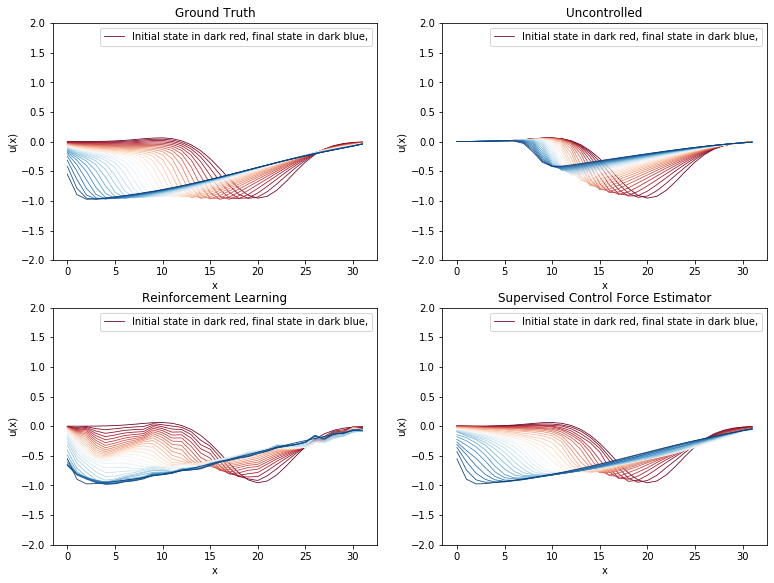

In [12]:
index_in_set = 8
fig, axs = plt.subplots(2, 2, figsize=(12.8, 9.6))

axs[0, 0].set_title('Ground Truth')
axs[0, 1].set_title('Uncontrolled')
axs[1, 0].set_title('Reinforcement Learning')
axs[1, 1].set_title('Supervised Control Force Estimator')

for subplot_idcs in [(0,0), (0,1), (1,0), (1,1)]:
    axs[subplot_idcs].set_ylim(-2, 2)
    axs[subplot_idcs].set_xlabel('x')
    axs[subplot_idcs].set_ylabel('u(x)')
    axs[subplot_idcs].legend(['Initial state in dark red, final state in dark blue,'])
    
def plot_w_label(xy, field): 
    color = bplt.gradient_color(0, step_count+1)
    axs[xy].plot(field[0][index_in_set].squeeze(), color=color, linewidth=0.8, label='Initial state in dark red, final state in dark blue,')
    axs[xy].legend()
    
# Plot the first states and create a legend for each plot
plot_w_label((0, 0), gt_frames)
plot_w_label((0, 1), pass_frames)
plot_w_label((1, 0), rl_frames)
plot_w_label((1, 1), cfe_frames)
    
# Plot the remaining states
for frame in range(1, step_count + 1):
    color = bplt.gradient_color(frame, step_count+1)
    plot = lambda xy, field: axs[xy].plot(field[frame][index_in_set].squeeze(), color=color, linewidth=0.8)
    plot((0,0), gt_frames)
    plot((0,1), pass_frames)
    plot((1,0), rl_frames)
    plot((1,1), cfe_frames)

In [13]:
def infer_forces(frames):
    frames = np.array(frames)
    
    b = Burgers(diffusion_substeps=diffusion_substeps)
    to_state = lambda v: BurgersVelocity(domain, velocity=v, viscosity=viscosity) 
        
    # Simulate all timesteps of all trajectories at once
    # => concatenate all frames in batch dimension
    prv = to_state(frames[:-1].reshape((-1,) + frames.shape[2:]))
    prv_sim = b.step(prv, dt=dt)
    
    forces = (frames[1:] - prv_sim.velocity.data.reshape(step_count, -1, *frames.shape[2:])) / dt
    
    # Sanity check, should be able to reconstruct goal state with forces
    s = to_state(frames[0])
    for i in range(step_count):
        f = forces[i].reshape(s.velocity.data.shape)
        effect = FieldEffect(CenteredGrid(f, box=domain.box), ['velocity'])
        s = b.step(s, dt, (effect,))
    diff = frames[-1] - s.velocity.data
    print('Maximum deviation from target state: %f' % np.abs(diff).max())
    return forces

    
gt_forces = np.abs(infer_forces(gt_frames)).sum(axis=(0, 2)).squeeze()
cfe_forces = np.abs(infer_forces(cfe_frames)).sum(axis=(0, 2)).squeeze()
rl_forces = rl_trainer.infer_test_set_forces()

Maximum deviation from target state: 0.000000
Maximum deviation from target state: 0.000000


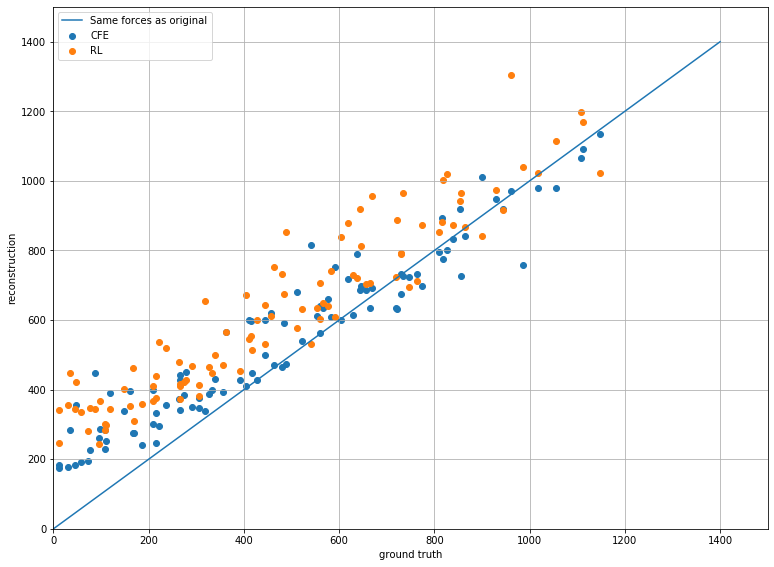

In [14]:
plt.figure(figsize=(12.8, 9.6))
plt.scatter(gt_forces, cfe_forces, label='CFE')
plt.scatter(gt_forces, rl_forces, label='RL')
plt.plot([x * 100 for x in range(15)], [x * 100 for x in range(15)], label='Same forces as original')
plt.xlabel('ground truth')
plt.xlim(0, 1500)
plt.ylim(0, 1500)
plt.ylabel('reconstruction')
plt.grid()
plt.legend()
plt.show()

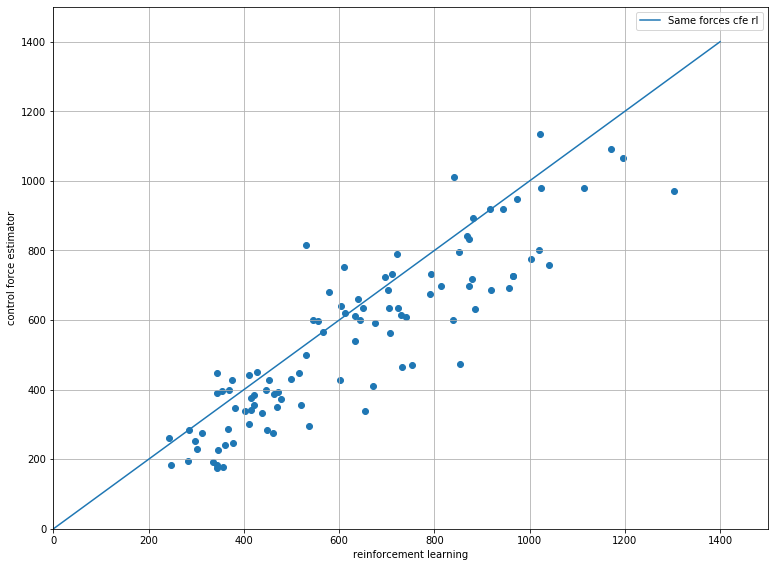

In [15]:
plt.figure(figsize=(12.8, 9.6))
plt.scatter(rl_forces, cfe_forces)
plt.xlabel('reinforcement learning')
plt.ylabel('control force estimator')
plt.plot([x * 100 for x in range(15)], [x * 100 for x in range(15)], label='Same forces cfe rl')
plt.xlim(0, 1500)
plt.ylim(0, 1500)
plt.grid()
plt.legend()
plt.show()

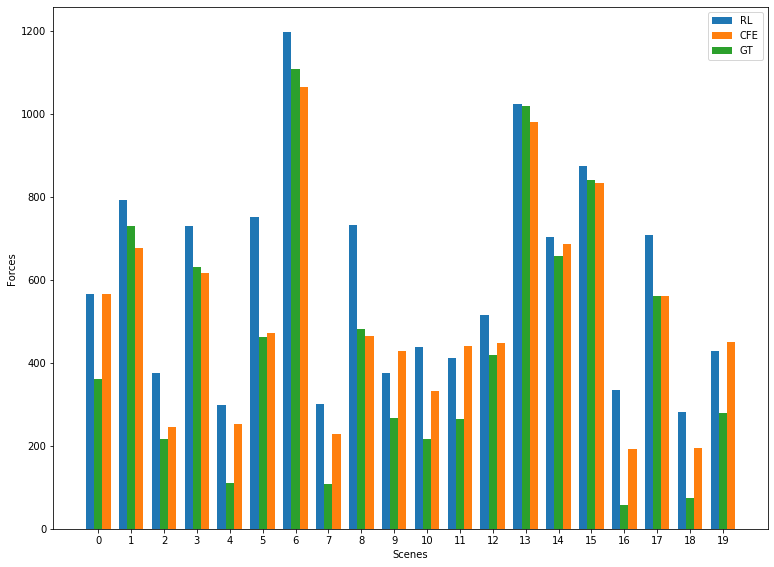

In [16]:
w=0.25
plot_count=20
plt.figure(figsize=(12.8, 9.6))
plt.bar([i - w for i in range(plot_count)], rl_forces[:plot_count], width=w, align='center', label='RL')
plt.bar([i + w for i in range(plot_count)], cfe_forces[:plot_count], width=w, align='center', label='CFE')
plt.bar([i for i in range(plot_count)], gt_forces[:plot_count], width=w, align='center', label='GT')
plt.xlabel('Scenes')
plt.xticks(range(plot_count))
plt.ylabel('Forces')
plt.legend()
plt.show()